In [1]:
import os
import numpy as np
import pandas as pd
from itertools import chain
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib import patches
from matplotlib.path import Path
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import font_manager
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import allensdk.core.swc as swc
from morph_utils.templates import load_layer_template
from neuron_morphology.swc_io import morphology_from_swc
from morph_utils.measurements import leftextent, rightextent

from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from scikit_posthocs import posthoc_dunn

import anndata as ad

from svgpathtools import svg2paths
import io
import cairosvg  

import random
import operator
import warnings

from template_utils import plot_ttype_viewer, plot_ttype_histos, plot_subclass_eta2, plot_subclass_eta2_topn, plot_subclass_boxplot, plot_ttype_viewer_histos, \
                           get_tx_order_dict #, add_layer_aligned_paths, 
from template_utils_v2 import natural_sort_key, plot_dendrite_depth_profiles_swb, plot_axon_depth_profiles_swb, plot_prop_for_mets_swb, \
                              plot_dendrite_depth_profiles_subclass, plot_axon_depth_profiles_subclass, basic_morph_plot, adjust_lightness
from template_utils_v3 import plot_ephys_rheo, plot_ephys_subthresh, plot_subclass_heatmap
from template_utils_v5 import plot_donor_lobe_counts, plot_supertype_counts, plot_spatial_slice, plot_morph_lineup_swb, plot_spatial_density_kde, plot_abundance, \
                              plot_ref_umap_crop, plot_ref_umap, process_fi_curves, plot_avg_fi_for_mets, plot_ap_subclass, plot_ap_ttype, plot_morpho_gallery, \
                              plot_ephys_gallery, plot_umap, plot_distal_apicals, process_distal_apicals, overlay_morphologies, get_spatial_density_kde, plot_precomputed_kde, \
                              abundance_barplot
from template_utils_v6 import plot_subclass_hairballs

import pickle

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, add_swc_paths, get_tx_order

SEAAD_COLORS = get_seaad_colors()


Params

In [2]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

In [3]:
#ephys feature rename dict 
ephys_feature_rename_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ephys_feature_rename.csv')
ephys_feature_rename_dict = dict(zip(ephys_feature_rename_df.old_feature_name, ephys_feature_rename_df.new_feature_name))

#morpho feature rename dict 
morpho_feature_rename_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\morpho_feature_rename.csv')
morpho_feature_rename_dict = dict(zip(morpho_feature_rename_df.old_feature_name, morpho_feature_rename_df.alt_new_feature_name))

feature_type_color_dict = {
    'soma': 'grey', 
    'axon': "firebrick", 
    'basal': "steelblue",
    'both' : '#02c225',
    'apical': "orange", }

morpho_feature_color_dict = dict(zip(morpho_feature_rename_df.alt_new_feature_name, [feature_type_color_dict[t.strip()] for t in morpho_feature_rename_df.type.tolist()]))

In [4]:
flatten = lambda l: list(chain.from_iterable(l))

In [5]:
acute_only = False #whether to exclude all culture cells 
mark_paradigm = True #whether to have the scatter marker differentiate paradigm 
mark_paradigm_type = 'oo' #'xo', 'oo' #the type of marker if mark_paradigm == True 

Load data

In [6]:
#load morpho & ephys data

morpho_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
morpho_data_root_axon = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\axon'
layer_aligned_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\SWC_LayerAligned' #path to folder with layer aligned swcs for these cells 
# layer_aligned_depths_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\soma_depth\20251029_human_layer_aligned_depth\20251029_layer_aligned_depth.csv'
ephys_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\20251008_ephys_features_imputed.csv'

abundance_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\abundance\20250627\SEAAD_ref_counts.csv'
metadata_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20251008\Datalock_Human_Glut_4_4_25(patchseq_mapping_results).csv'

isodepth_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\isodepth\20250624\20250624_isodepths.csv'

spatial_slice_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\spatial\20250711\H1930002Cx46MTG202007105_subset_section_qcd.h5ad'
spatial_slice_layer_overlay_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\spatial\20251028\slice_crop_layer_overlay.png'

reference_umap_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\reference\20250710_umap\patchseq_Annotations_and_Analysis_update\FACS_patchseq_QC_and_UMAP.csv'

ephys_subthresh_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250801\ephys_subthresh' #location of ephys subthreshold data
ephys_fi_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\20251008_ephys_fi_curve_data.csv'
ephys_ap_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251007_ap_phase_data\human_exc_ap_phase_data.npy'

heatmap_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad' #location of kde heatmap data

gallery_cells = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\viewers\human_excitatory_gallery_viewer_dendrite.csv')
svg_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250801\ephys_trace_svgs'

m_umap_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\M_UMAP\dendrite\human_excitatory_umap_2d_nn15_md0.1_all.csv'
e_umap_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\E_UMAP\human_excitatory_ephys_umap_2d_nn15_md0.1_withDepth.csv'
me_umap_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\ME_UMAP\dendrite\human_excitatory_umap_2d_nn15_md0.1_all.csv'

#Get L2 L3 ttype split

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L23_ttype_rename.json", "r") as f:
    L23_ttype_rename_dict = json.load(f)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_layer_dict.json", "r") as f:
    ttype_to_layer_dict = json.load(f)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_subclass_dict.json", "r") as f:
    ttype_to_subclass_dict = json.load(f)

output_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251201_seaad\ME_templates\dendrite'
if acute_only:
    output_dir = os.path.join(output_dir, 'acute_only')
os.makedirs(output_dir, exist_ok=True)

metadata = pd.read_csv(metadata_path, encoding='latin1')
metadata[subclass_col] = metadata[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
metadata[cluster_col] = metadata[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
metadata[cluster_col] = metadata[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata['layer'] = metadata[cluster_col].map(ttype_to_layer_dict)
#split Layer 2 and 3 subclass
metadata["layer_subclass"] = metadata.apply(lambda row: "L2 IT" if row["layer"] == 'Layer 2' else ("L3 IT" if row["layer"] == 'Layer 3' else row[subclass_col]), axis=1)
metadata["layer_split"] = metadata.apply(lambda row: "L2" if row["layer"] == 'Layer 2' else ("L3" if row["layer"] == 'Layer 3' else row['layer']), axis=1)

metadata_morph = pd.read_csv(os.path.join(morpho_data_root, 'metadata.csv'))
metadata_morph[subclass_col] = metadata_morph[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
metadata_morph[cluster_col] = metadata_morph[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
metadata_morph[cluster_col] = metadata_morph[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata_morph['layer'] = metadata_morph[cluster_col].map(ttype_to_layer_dict)
#split Layer 2 and 3 subclass
metadata_morph["layer_subclass"] = metadata_morph.apply(lambda row: "L2 IT" if row["layer"] == 'Layer 2' else ("L3 IT" if row["layer"] == 'Layer 3' else row[subclass_col]), axis=1)
metadata_morph["layer_split"] = metadata_morph.apply(lambda row: "L2" if row["layer"] == 'Layer 2' else ("L3" if row["layer"] == 'Layer 3' else row['layer']), axis=1)

metadata_morph_axon = pd.read_csv(os.path.join(morpho_data_root_axon, 'metadata.csv'), encoding='latin1')
metadata_morph_axon[subclass_col] = metadata_morph_axon[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
metadata_morph_axon[cluster_col] = metadata_morph_axon[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
metadata_morph_axon[cluster_col] = metadata_morph_axon[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata_morph['has_axon'] = metadata_morph.specimen_id.isin(metadata_morph_axon.specimen_id.astype(int).tolist())

#dendrite histograms
aligned_histogram = pd.read_csv(os.path.join(morpho_data_root, 'AlignedHistogram.csv'), index_col=0)
aligned_histogram *= 1.144 # approx. scaling to microns
all_cols = sorted(aligned_histogram.columns, key=natural_sort_key)
basal_cols = [c for c in all_cols if c.startswith("3_")]
apical_cols = [c for c in all_cols if c.startswith("4_")]
aligned_soma_depths = pd.read_csv(os.path.join(morpho_data_root, 'AlignedSomaDepths.csv'))
raw_feature_wide = pd.read_csv(os.path.join(morpho_data_root, 'RawFeatureWide.csv'))
raw_feature_wide = raw_feature_wide.rename(columns=morpho_feature_rename_dict) #rename feature names to be more interpretable

#axon histograms
aligned_histogram_axon = pd.read_csv(os.path.join(morpho_data_root_axon, 'AlignedHistogram.csv'), index_col=0)
aligned_histogram_axon *= 1.144 # approx. scaling to microns
all_cols = sorted(aligned_histogram_axon.columns, key=natural_sort_key)
axon_cols = [c for c in all_cols if c.startswith("2_")]
aligned_soma_depths_axon = pd.read_csv(os.path.join(morpho_data_root_axon, 'AlignedSomaDepths.csv'))
raw_feature_wide_axon = pd.read_csv(os.path.join(morpho_data_root_axon, 'RawFeatureWide.csv'))
raw_feature_wide_axon = raw_feature_wide_axon.rename(columns=morpho_feature_rename_dict)


ephys_data = pd.read_csv(ephys_path, index_col = 'specimen_id')
ephys_data = ephys_data.rename(columns=ephys_feature_rename_dict) #rename feature names to be more interpretable
ephys_feature_cols = [x for x in ephys_data.columns if not x.endswith('_qc') and not x.startswith('failed') and not x in ['cell_name', 'ephys?', 'ephys notes', 'specimen_name', subclass_col, 'feature_count']]
ephys_data = ephys_data[ephys_feature_cols]
metadata_ephys = pd.read_csv(metadata_path, encoding='latin1') #TODO can shift code so we don't have this redundant metadata copy
metadata_ephys[subclass_col] = metadata_ephys[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
metadata_ephys[cluster_col] = metadata_ephys[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
metadata_ephys[cluster_col] = metadata_ephys[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata_ephys['layer'] = metadata_ephys[cluster_col].map(ttype_to_layer_dict)
#split Layer 2 and 3 subclass
metadata_ephys["layer_subclass"] = metadata_ephys.apply(lambda row: "L2 IT" if row["layer"] == 'Layer 2' else ("L3 IT" if row["layer"] == 'Layer 3' else row[subclass_col]), axis=1)
metadata_ephys["layer_split"] = metadata_ephys.apply(lambda row: "L2" if row["layer"] == 'Layer 2' else ("L3" if row["layer"] == 'Layer 3' else row['layer']), axis=1)

ephys_fi_data = pd.read_csv(ephys_fi_file)

#subthreshold response
subthresh_spike_data = {}
for layer in ['L2', 'L3', 'L4', 'L5', 'L6']:
    subthresh_spike_data[layer] = np.load(os.path.join(ephys_subthresh_dir, 'subthreshold_data_{}.npy'.format(layer.replace('/','-').replace(' ', '_'))), allow_pickle=True)[()]
subthresh_metadata = pd.read_csv(os.path.join(ephys_subthresh_dir, 'subthreshold_metadata.csv'))  
subthresh_metadata['HANN_cluster_label_assignment_winner'] = subthresh_metadata['HANN_cluster_label_assignment_winner'].apply(lambda x: L23_ttype_rename_dict.get(x, x))

loaded_ephys_ap_file = np.load(ephys_ap_file, allow_pickle=True)
ephys_ap_dict = loaded_ephys_ap_file.item()
ephys_ap_dict['L2/3 IT'] = dict(zip([L23_ttype_rename_dict.get(k, k) for k in ephys_ap_dict['L2/3 IT'].keys()], ephys_ap_dict['L2/3 IT'].values()))

abundance_ref = pd.read_csv(abundance_path)
abundance_ref = abundance_ref[abundance_ref['class_label'] == 'Neuronal: Glutamatergic']
abundance_ref['supertype_frac_of_layer'] = abundance_ref['supertype_counts'] / abundance_ref.groupby('layer')['supertype_counts'].transform('sum')
abundance_ref_total_n = abundance_ref['supertype_counts'].sum()
abundance_ref['supertype_frac_of_class'] = abundance_ref['supertype_counts'].map(lambda x: x/abundance_ref_total_n)
abundance_ref['supertype'] = abundance_ref['supertype'].apply(lambda x: L23_ttype_rename_dict.get(x, x))

abundance_pseq = pd.read_csv(metadata_path, encoding='latin1')
abundance_pseq[subclass_col] = abundance_pseq[subclass_col].replace('L5 ET_ME', 'L5 ET').replace('L5 ET(ME)', 'L5 ET')
abundance_pseq[cluster_col] = abundance_pseq[cluster_col].replace('L5 ET_ME', 'L5 ET(ME)')
abundance_pseq[cluster_col] = abundance_pseq[cluster_col].apply(lambda x: L23_ttype_rename_dict.get(x, x))
abundance_pseq = abundance_pseq[abundance_pseq['Transcriptomics '] == True][[subclass_col, cluster_col]]

isodepth_df = pd.read_csv(isodepth_file)
isodepth_df = isodepth_df[isodepth_df['SEAAD_Class_name'] == 'Neuronal: Glutamatergic']
isodepth_df['SEAAD_Supertype_name'] = isodepth_df['SEAAD_Supertype_name'].apply(lambda x: L23_ttype_rename_dict.get(x, x))
spatial_slice_data = ad.read_h5ad(spatial_slice_file)
spatial_slice_data.obs['SEAAD_Supertype_name'] = spatial_slice_data.obs['SEAAD_Supertype_name'].apply(lambda x: L23_ttype_rename_dict.get(x, x))

reference_umap = pd.read_csv(reference_umap_file)
reference_umap = reference_umap[~((reference_umap['UMAP_1'] == 0) & (reference_umap['UMAP_2'] == 0))] # Filter out (0, 0) points
reference_umap['celltype'] = reference_umap['celltype'].apply(lambda x: L23_ttype_rename_dict.get(x, x))

temp = metadata_ephys[~metadata_ephys['cell_id'].isna()][['cell_id', subclass_col]]
temp['cell_id'] = temp['cell_id'].astype(int)
m_umap = pd.read_csv(m_umap_file).merge(temp, how='left', left_on='specimen_id', right_on='cell_id')
e_umap = pd.read_csv(e_umap_file).merge(temp, how='left', left_on='specimen_id', right_on='cell_id')
me_umap = pd.read_csv(me_umap_file).merge(temp, how='left', left_on='specimen_id', right_on='cell_id')

species = 'human'
layer_info, layer_labels, layer_colors = load_layer_template(species)
layers = ['L4', 'L5', 'L6'] #'L2/3', 

with open(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\colors\lobe_colors.json', 'r') as f:
    lobe_colors = json.load(f)

with open(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\colors\paradigm_colors.json', 'r') as f:
    paradigm_colors = json.load(f)

#get transcriptomic order 
subclass_order_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\subclass_order.txt'
ttype_order_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_order.txt'
tx_order_dict = get_tx_order_dict(subclass_order_file=subclass_order_file, ttype_order_file=ttype_order_file)
TTYPE_ORDER, SUBCLASS_ORDER = get_tx_order()


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Organize data

In [7]:
#data wrangling

#combine data and get la file paths 
metadata_morph_axon = metadata_morph_axon.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata_morph_axon = metadata_morph_axon[['specimen_id', 't_type', 'subclass_label','lobe']]
metadata_morph_axon['specimen_id'] = metadata_morph_axon['specimen_id'].astype('int')
# metadata_morph_axon['subclass_label'] = metadata_morph_axon['subclass_label'].replace('L5 ET_ME', 'L5 ET')

#combine data and get la file paths 
metadata_morph = metadata_morph.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata_morph = metadata_morph[['specimen_id', 't_type', 'subclass_label', 'layer_subclass', 'lobe', 'layer_split', 'has_axon']] #, 'seuratQCpass']]
metadata_morph['specimen_id'] = metadata_morph['specimen_id'].astype('int')
# metadata_morph['subclass_label'] = metadata_morph['subclass_label'].replace('L5 ET_ME', 'L5 ET')

#add layer data
metadata_morph['layer'] = metadata_morph['subclass_label'].apply(
    lambda x: next((layer for layer in ['L2/3', 'L4', 'L5', 'L6'] if x.startswith(layer)), None)
)
#remove vals without a seaad mapping
metadata_morph['t_type'] = metadata_morph['t_type'].fillna('TBD')
metadata_morph['subclass_label'] = metadata_morph['subclass_label'].fillna('TBD')

#morpho features
morpho_data = metadata_morph.merge(aligned_soma_depths, how='inner', on='specimen_id')
# morpho_data = morpho_data.merge(layer_aligned_soma_depths, how='inner', on='specimen_id')
morpho_data = add_swc_paths(morpho_data, layer_aligned_dir, column_name='SWC_layer_aligned')
morpho_data_axon = metadata_morph_axon.merge(aligned_soma_depths_axon, how='inner', on='specimen_id')
morpho_data_axon = add_swc_paths(morpho_data_axon, layer_aligned_dir, column_name='SWC_layer_aligned')


morpho_data = morpho_data.merge(raw_feature_wide, how='inner', on='specimen_id') 
morpho_data_axon = morpho_data_axon.merge(raw_feature_wide_axon, how='inner', on='specimen_id') 

#sort the cells
morpho_sorted_data = morpho_data.sort_values(by=['t_type', 'soma_distance_from_pia'])

#delete columns where any vals are nan
morpho_sorted_clean_data = morpho_sorted_data.dropna(axis=1, how='all')

#combine data and get la file paths 
metadata_ephys = metadata_ephys.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'}) 
metadata_ephys = metadata_ephys[~metadata_ephys.specimen_id.isna()]
metadata_ephys = metadata_ephys[['specimen_id', 't_type', 'subclass_label', 'layer_subclass', 'lobe', 'layer_split', 'depth_from_pia_norm', 'paradigm']] #, 'seuratQCpass']]
metadata_ephys['specimen_id'] = metadata_ephys['specimen_id'].astype(int)

#add layer data
metadata_ephys['layer'] = metadata_ephys['subclass_label'].apply(
    lambda x: next((layer for layer in ['L2/3', 'L4', 'L5', 'L6'] if x.startswith(layer)), None)
)

#remove vals without a seaad mapping
metadata_ephys['t_type'] = metadata_ephys['t_type'].fillna('TBD')
metadata_ephys['subclass_label'] = metadata_ephys['subclass_label'].fillna('TBD')

#map the normalized depth in pia to the average layer pia/wm values 
avg_pia = layer_info['1']
avg_wm = layer_info['wm']
metadata_ephys['depth_from_pia_norm_to_layers'] = metadata_ephys['depth_from_pia_norm'].apply(lambda x: x * (avg_wm - avg_pia) + avg_pia if pd.notnull(x) else np.nan)

#prepare soma depths for fig1 - layer aligned if has morpho, else normed distance adjusted to pia/wm avg template
soma_depths = aligned_soma_depths.merge(metadata_ephys[['specimen_id', 'depth_from_pia_norm_to_layers']], how='outer', on='specimen_id')
soma_depths['fig1_soma_depth'] = soma_depths['soma_distance_from_pia'].fillna(soma_depths['depth_from_pia_norm_to_layers'])
soma_depths = soma_depths.merge(metadata[['cell_id', subclass_col, cluster_col]], how='outer', left_on='specimen_id', right_on='cell_id').dropna(subset=['fig1_soma_depth'])
soma_depths = soma_depths.rename(columns={cluster_col: "t_type", subclass_col:'subclass_label'})[['specimen_id', 't_type', 'subclass_label', 'fig1_soma_depth']]

#add ephys features
ephys_data = metadata_ephys.merge(ephys_data, how='inner', on='specimen_id')

#ephys features
ephys_fi_data_formatted, bins = process_fi_curves(ephys_fi_data.set_index('specimen_id'))
ephys_fi_data_formatted = ephys_fi_data_formatted.merge(ephys_data, how='inner', left_index=True, right_on='specimen_id')

#sort the cells
ephys_sorted_data = ephys_data.sort_values(by=['t_type'])  #TODO is there an ephys feature to sort by? #, 'soma_distance_from_pia'])

#delete columns where any vals are nan
ephys_sorted_clean_data = ephys_sorted_data.dropna(axis=1, how='all')
ephys_sorted_clean_data['AP width (ms)'] = ephys_sorted_clean_data['AP width (ms)'] * 1000 #This column needs conversion from sec to ms

morpho_sorted_clean_data.set_index('specimen_id', inplace=True)
morpho_data_axon.set_index('specimen_id', inplace=True)

layer_edges = layer_info.values()

In [8]:
# ephys_data.to_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\bl_code\20251027\ephys_data.csv', index=False)
# ephys_fi_data.to_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\bl_code\20251027\ephys_fi_data.csv', index=False)

In [9]:
# Function to assign color label
def color_label(row, col):
    if row['lobe'] != 'TemL':
        return 'gray'
    else:
        return row[col]

# Correct usage of apply with additional argument
morpho_sorted_clean_data['t_type_teml'] = morpho_sorted_clean_data.apply(color_label, axis=1, args=('t_type',))
morpho_sorted_clean_data['subclass_label_teml'] = morpho_sorted_clean_data.apply(color_label, axis=1, args=('subclass_label',))

ephys_sorted_clean_data['t_type_teml'] = ephys_sorted_clean_data.apply(color_label, axis=1, args=('t_type',))
ephys_sorted_clean_data['subclass_label_teml'] = ephys_sorted_clean_data.apply(color_label, axis=1, args=('subclass_label',))

#rename L23 ttypes in colordict 
SEAAD_COLORS = dict(zip([L23_ttype_rename_dict.get(k, k) for k in SEAAD_COLORS.keys()], SEAAD_COLORS.values()))
color_dict = SEAAD_COLORS

color_dict.update({'gray': "#000000FF"})


In [10]:
#template plotting specs
group_layer_edges = {
    'L2/3': list(layer_edges)[:5],
    'L4':  list(layer_edges), #[:5],
    'L5':  list(layer_edges),
    'L6' :  list(layer_edges)
}

group_layer_labels = {
    'L2/3' : {k: layer_labels[k] for k in ('L1', 'L2', 'L3', 'L4')},
    'L4' : layer_labels, #{k: layer_labels[k] for k in ('L1', 'L2', 'L3', 'L4')}, 
    'L5':  layer_labels,
    'L6':  layer_labels
}

group_height_ratios = {
    'L2/3': (4, 3.5, 2, 1),
    'L4': (2, 3, 2.1, 0.8), 
    'L5': (1.8, 1.6, 1.6, 0.5), #(4, 3.5, 2, 1),
    'L6': (3.5, 1.8, 2.5, 1),
    'subclass': (3, 1, 3, 3, 2, 1)
}

group_fig_size = {
    'L2/3': (13, 13.5),
    'L4': (10, 9), #10),
    'L5': (10, 10.5), #(13, 13.5),
    'L6': (10, 9),
    'subclass': (13, 20),
    'subclass_1' : (13, 10),
    'subclass_2' : (13, 10)
}

group_morph_spacing = {
    'L2/3': 600, 
    'L4': 700, 
    'L5': 1200, 
    'L6': 700
}

group_supertype_split = {
    'L2/3': 5, 
    'L4': None,
    'L5': 5, 
    'L6': None #5
}

abundance_radius = {
    'L2/3': 1, 
    'L4': 1, 
    'L5': 1,
    'L6': 1
}

ref_umap_axes_lims = { #[(xmin, xmax), (ymin, ymax)]
    'L2/3': [(-12.5, -7), (-8.5, 2)], 
    'L4': [(-10, 8), (-1, 8)], 
    'L5': [(-6, 8), (-10.5, 17)],
    'L6': [(-2, 18), (-14, 4)]
}


meta_ax_width_ratios = {
    'L2/3': (1,0.7,3.3,1), 
    'L4': (1,0.7,1.8,2.5), 
    'L5': (1, 2.7, 1), #(0.7,1.5,3,1.5),
    'L6': (0.8, 2.5, 1.5) #(0.7,1.5,2.5,1.5)
}

spatial_cols = {
    'L2/3': 4, #5
    'L4': 2, 
    'L5': 7, #5
    'L6': 8 #4
}

umap_labels = {
    'L2/3' : {'L2/3 IT_6' : {'x':-12.5, 'y':-4.5, 'ha': 'right', 'va':'center'},
                 'L2/3 IT_1' : {'x':-10 , 'y':-7.5 , 'ha': 'right', 'va': 'center'},
                 'L2/3 IT_7' : {'x': -12.5, 'y': -3.5, 'ha': 'right', 'va': 'center'},
                 'L2/3 IT_8' : {'x': -12.5, 'y': -6, 'ha': 'right', 'va': 'center'},
                 'L2/3 IT_12' : {'x':-12 , 'y': -2.5, 'ha': 'right', 'va': 'center'},
                 'L2/3 IT_10' : {'x':-9 , 'y': -3, 'ha': 'left', 'va': 'center'},
                 'L2/3 IT_13' : {'x':-8.5 , 'y': -2, 'ha': 'left', 'va': 'center'},
                 'L2/3 IT_5' : {'x': -8.5, 'y': -1, 'ha': 'left', 'va': 'center'},
                 'L2/3 IT_3' : {'x': -11, 'y': 1, 'ha': 'right', 'va': 'center'},
                 'L2/3 IT_2' : {'x': -8, 'y': -8, 'ha': 'left', 'va': 'center'},
                 'L4 IT' : {'x': -8, 'y': 2.5, 'ha': 'left', 'va': 'center'}
                 },
    'L4' : {'L4 IT_3' : {'x':-8.5, 'y':-0.5, 'ha': 'left', 'va': 'center'}, 
               'L4 IT_4' : {'x':-6.5, 'y':3, 'ha': 'left', 'va': 'center'}, 
               'L4 IT_2' : {'x':-6, 'y':0, 'ha': 'left', 'va': 'center'}, 
               'L4 IT_1' : {'x':4, 'y':6.5, 'ha': 'right', 'va': 'center'},
               'L2/3 IT' : {'x': -9.5, 'y': 1.5, 'ha': 'right', 'va': 'center'},
               'L5 IT' : {'x': 0, 'y': 4, 'ha': 'left', 'va': 'center'},
               'L6 IT' : {'x': 3.5, 'y': 0, 'ha': 'right', 'va': 'center'}
               },
    'L5' : {'L5 IT_6' : {'x':7.5, 'y':4, 'ha':'left', 'va': 'center'},
               'L5 IT_5' : {'x':7, 'y':5.5, 'ha':'left', 'va': 'center'},
               'L5 IT_2' : {'x':3, 'y':5, 'ha':'right', 'va': 'center'},
               'L5 IT_1' : {'x':-2, 'y':3, 'ha':'right', 'va': 'center'},
               'L5 IT_7' : {'x':4, 'y':3, 'ha':'right', 'va': 'center'},
               'L5 IT_3' : {'x':-1, 'y':1, 'ha':'left', 'va': 'center'},
               'L5/6 NP_2' : {'x':4, 'y':15, 'ha':'left', 'va': 'center'},
               'L5/6 NP_6' : {'x':0, 'y':15, 'ha':'right', 'va': 'center'},
               'L5/6 NP_1' : {'x':3.5, 'y':14, 'ha':'left', 'va': 'center'},
               'L5/6 NP_3' : {'x':0, 'y':17, 'ha':'left', 'va': 'center'},
               'L5/6 NP_4' : {'x':0, 'y':13, 'ha':'left', 'va': 'center'},
               'L5 ET_1' : {'x':3.5, 'y':-9.5, 'ha':'left', 'va': 'center'},
               'L5 ET_2' : {'x':4, 'y':-7, 'ha':'left', 'va': 'center'},
               'L4 IT' : {'x': -2, 'y': 7, 'ha': 'left', 'va': 'center'},
               'L6 IT' : {'x': 5, 'y': -1, 'ha': 'right', 'va': 'center'}
               },
    'L6' : { 'L6 CT_3' : {'x':14, 'y':2, 'ha':'right', 'va': 'center'},
                'L6 CT_2' : {'x':16, 'y':4, 'ha':'right', 'va': 'center'},
                'L6 CT_4' : {'x':15.5, 'y':0.5, 'ha':'left', 'va': 'center'},
                'L6 CT_1' : {'x':17, 'y':3, 'ha':'left', 'va': 'center'},
                'L6 IT_2' : {'x':3, 'y':2, 'ha':'right', 'va': 'center'},
                'L6 IT_1' : {'x':5, 'y':-0.5, 'ha':'right', 'va': 'center'},
                'L6 IT Car3_1' : {'x':0, 'y':-10, 'ha':'right', 'va': 'center'},
                'L6 IT Car3_3' : {'x':-2, 'y':-12, 'ha':'right', 'va': 'center'},
                'L6 IT Car3_2' : {'x':0.5, 'y':-12.5, 'ha':'left', 'va': 'center'},
                'L6b_6' : {'x':12.5, 'y':-4, 'ha':'right', 'va': 'center'},
                'L6b_3' : {'x':14, 'y':-6, 'ha':'right', 'va': 'center'},
                'L6b_5' : {'x':15, 'y':-3.5, 'ha':'left', 'va': 'center'},
                'L6b_1' : {'x':17.5, 'y':-6.5, 'ha':'right', 'va': 'center'},
                'L6b_4' : {'x':17.5, 'y':-4.5, 'ha':'right', 'va': 'center'},
                'L6b_2' : {'x':15, 'y':-1, 'ha':'left', 'va': 'center'},
                'L5 IT' : {'x': 0.5, 'y': 3.3, 'ha': 'left', 'va': 'center'},
                'L5 ET' : {'x': 3, 'y': -8.5, 'ha': 'left', 'va': 'center'}
                },
    'subclass' : {'L2/3 IT' : {'x':-8.2, 'y':-4, 'ha': 'left', 'va':'center'},
                  'L4 IT' : {'x':-1.9, 'y':6.3, 'ha': 'left', 'va':'center'},
                  'L5 IT' : {'x':0, 'y':4, 'ha': 'left', 'va':'center'},
                  'L5/6 NP' : {'x':3.2, 'y':13.8, 'ha': 'left', 'va':'center'},
                  'L5 ET' : {'x':3, 'y':-8.3, 'ha': 'left', 'va':'center'},
                  'L6 IT Car3' : {'x':0.9, 'y':-12, 'ha': 'left', 'va':'center'},
                  'L6 IT' : {'x':5, 'y':0, 'ha': 'left', 'va':'center'},
                  'L6 CT' : {'x':14, 'y':1.5, 'ha': 'right', 'va':'center'},
                  'L6b' : {'x':13, 'y':-3, 'ha': 'right', 'va':'center'},
                  'reference' : {'x':14, 'y':-6.8, 'ha': 'left', 'va':'center'}
                 }
}

umap_lines = {
    'L2/3' : [],
    'L4' : [{'x_values':[1, 3.4], 'y_values':[4.2, 4.5]},
            {'x_values':[0, -1], 'y_values':[3.7, 2.5]}],
    'L5' : [{'x_values':[-2.2, -5.2], 'y_values':[6.5, 2.2]},
            {'x_values':[-0.2, 4.2], 'y_values':[7, 6.6]}],
    'L6' : [{'x_values':[-0.8, 0.3], 'y_values':[2.4, 3.1]},
            {'x_values':[1.8, 3.8], 'y_values':[3.3, 3.3]}],
    'subclass' : [{'x_values':[-0.1, 3.9], 'y_values':[6.4, 6.4]},
                  {'x_values':[-2.2, -5.2], 'y_values':[5.9, 2.3]},
                  {'x_values':[-0.9, -0.2], 'y_values':[2.6, 3.5]},
                  {'x_values':[1.8, 3.8], 'y_values':[4, 4]}]
}

umap_legend_locs = {
    'L2/3' : None,
    'L4' : [1,-1],
    'L5' : None,
    'L6' : [7,-12],
    'subclass' : None,
}

umap_legend_lengths = {
    'L2/3' : 1,
    'L4' : 1,
    'L5' : 2,
    'L6' : 2,
    'subclass' : 1,
}


ap_layer_dict = {
    'L2/3' :'L2-3IT',
    'L4': 'L4IT',
    'L5': 'L5ITETNP',
    'L6': 'L6ITCTb'
}

fi_xlim = {
    'L2/3': (0, 250), 
    'L4': (0,190),
    'L5': (0, 250), 
    'L6': (0, 250)
}

fi_ylim = {
    'L2/3': (0, 25), 
    'L4': (0, 25), 
    'L5': (0, 25), 
    'L6': (0, 15),
}

axon_viewer = {
    'L2/3': False, 
    'L4': True, 
    'L5': False, 
    'L6':False
}

plot_apical_tips = {
    'L2/3': False, 
    'L4': True, 
    'L5': True, 
    'L6':False
}

split_spatial_density = {
    'L2/3': False, 
    'L4': False, 
    'L5': True, 
    'L6': True
}

split_spatial_groups = {
    'L5' : [s for s in SUBCLASS_ORDER if s in ['L5 IT', 'L5/6 NP', 'L5 ET']],
    'L6' : [s for s in SUBCLASS_ORDER if s in ['L6 IT Car3', 'L6 IT', 'L6 CT', 'L6b']]
}


layer_num_cells_per_ttype = {
    'L2/3': 5, 
    'L4': 10, 
    'L5': 5, 
    'L6': 5
}

skip_slice_subplot_idxs = {
    'L2/3': [], 
    'L4': [], 
    'L5': [6], 
    'L6': []
}

morpho_feature_skip = {
    'L2/3': [], 
    'L4': [], 
    'L5': ['fraction of apical below basal'], 
    'L6': []
}

ephys_feature_swap = {
    'L2/3': {}, 
    'L4': {}, 
    'L5': {' Adaptation mean':'AP width (ms)'}, 
    'L6': {'ISI adaptation ratio': 'AP up/down ratio'}
}

# Layer Templates

### Analysis

Morpho Viewer

In [11]:
subclass_order_dict = {
    'L2/3' : ['L2/3 IT'], 
    'L4' : ['L4 IT'], 
    'L5' : ['L5 IT', 'L5/6 NP', 'L5 ET'], #, 'L5 ET(ME)'
    'L6' : ['L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b']
}

In [12]:
#prep for viewer section
# num_cells_per_ttype = 5

morpho_viewer_cells = {}
for layer in layers:
    sorted_cells_ttype = morpho_sorted_clean_data[morpho_sorted_clean_data['layer'] == layer]

    # --- sample evenly across soma depth, prioritizing TemL ---
    def sample_representative(group, n=layer_num_cells_per_ttype[layer]):
        teml_cells = group[group['lobe'] == 'TemL'].sort_values('soma_distance_from_pia')

        def even_sample(df, n):
            if len(df) <= n:
                return df
            return df.iloc[np.linspace(0, len(df) - 1, n, dtype=int)]

        if len(teml_cells) >= n:
            sampled = even_sample(teml_cells, n)
        else:
            sampled = teml_cells.copy()
            remaining = n - len(sampled)
            other_cells = group[group['lobe'] != 'TemL'].sort_values('soma_distance_from_pia')
            sampled_others = even_sample(other_cells, remaining)
            sampled = pd.concat([sampled, sampled_others], ignore_index=True)

        return sampled

    temp = (
        sorted_cells_ttype
        .reset_index()
        .groupby('t_type', group_keys=False)
        .apply(sample_representative)
        .reset_index(drop=True)
    )

    # set subclass order
    temp['subclass_label'] = pd.Categorical(
        temp['subclass_label'],
        categories=subclass_order_dict[layer],
        ordered=True
    )

    # set t_type order based on subclass-specific order
    temp['t_type'] = temp.apply(
        lambda row: pd.Categorical(
            [row['t_type']],
            categories=tx_order_dict[row['subclass_label']],
            ordered=True
        )[0],
        axis=1
    )

    # final sort
    morpho_viewer_cells[layer] = temp.sort_values(
        by=['subclass_label', 't_type', 'soma_distance_from_pia']
    )




#same but for axon for L4
with open(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L4_axon_viewer_cells.txt', 'r') as f:
    l4_axon_viewer_specimen_ids = [int(line.strip()) for line in f]

morpho_viewer_cells_axon = {}
sorted_cells_ttype = morpho_data_axon[morpho_data_axon.index.isin(l4_axon_viewer_specimen_ids)]


# --- sample evenly across soma depth, prioritizing TemL ---
def sample_representative(group, n=7):
    teml_cells = group[group['lobe'] == 'TemL'].sort_values('soma_distance_from_pia')

    def even_sample(df, n):
        if len(df) <= n:
            return df
        return df.iloc[np.linspace(0, len(df) - 1, n, dtype=int)]

    if len(teml_cells) >= n:
        sampled = even_sample(teml_cells, n)
    else:
        sampled = teml_cells.copy()
        remaining = n - len(sampled)
        other_cells = group[group['lobe'] != 'TemL'].sort_values('soma_distance_from_pia')
        sampled_others = even_sample(other_cells, remaining)
        sampled = pd.concat([sampled, sampled_others], ignore_index=True)

    return sampled

temp = (
    sorted_cells_ttype
    .reset_index()
    .groupby('t_type', group_keys=False)
    .apply(sample_representative)
    .reset_index(drop=True)
)


temp['subclass_label'] = pd.Categorical(temp['subclass_label'], categories=subclass_order_dict['L4'], ordered=True)

temp['t_type'] = temp.apply(lambda row: pd.Categorical([row['t_type']], categories=tx_order_dict[row['subclass_label']], ordered=True)[0],axis=1)

temp = temp.reset_index()
morpho_viewer_cells_axon['L4'] = temp.sort_values(by=['subclass_label', 't_type', 'soma_distance_from_pia'])






Apical tips

In [ ]:
ttype_apical_dict = {}
ttype_apical_buffer_dict = {}
for layer in ['L4', 'L5']:
    subclasses = subclass_order_dict[layer]
    ttype_order = flatten([tx_order_dict[sub] for sub in subclasses if sub in tx_order_dict])
    ttype_apical_dict[layer] = process_distal_apicals(morpho_sorted_clean_data, ttype_order, 't_type')

    temp_buffer_dict={}
    for t in ttype_order:
        temp_buffer_dict[t] = 50
    ttype_apical_buffer_dict[layer] = temp_buffer_dict


ttype_apical_buffer_dict['L5/6 NP_4'] = 400
ttype_apical_buffer_dict['L5 ET_1'] = 800
ttype_apical_buffer_dict['L5 ET_2'] = 700
ttype_apical_buffer_dict[ 'L5 ET(ME)'] = 1200

Morpho Eta2 and FDR corrected KW of ttypes within each subclass

In [15]:
features = raw_feature_wide.columns.tolist()[1:]

# subclass x feature stats
group_var = 'layer'
group_var_order = list(subclass_order_dict.keys())

morpho_eta_squared_group = dict()
morpho_kw_pvals_fdr_group = dict()
morpho_dunn_pvals_fdr_group = dict()

for group in group_var_order:
    print(group)
    group_data = morpho_sorted_clean_data.loc[morpho_sorted_clean_data[group_var] == group]

    # Get t-types in the current group
    x_var = 't_type'
    x_var_order = flatten([tx_order_dict[subclass] for subclass in group_data.subclass_label.unique()])

    # Initialize dictionaries for Kruskal-Wallis H test and p-values
    kw_hvals = dict()
    kw_pvals = dict()

    # Iterate over features to calculate KW test and eta-squared
    for f in features:
        # Get groups of data for each t-type
        t_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

        # Only include non-empty groups with at least 1 cell
        t_groups = [g for g in t_groups if len(g) >= 1]

        if len(t_groups) < 2:
            print(f"Not enough t_groups with data for feature {f}")
            continue

        try:
            hvalue, pvalue = stats.kruskal(*t_groups, nan_policy='omit')
            kw_hvals[f] = hvalue
            kw_pvals[f] = pvalue
        except ValueError as e:
            print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

    # FDR correction for KW p-values
    kw_pvals_list = list(kw_pvals.values())
    kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

    kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
    kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

    # Post-hoc Dunn test for significant KW features (after FDR correction)
    dunn_pvals_fdr = dict()
    for k, v in kw_rejected.items():
        if v:  # only if null hypothesis was rejected
            dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

    # Calculate eta-squared for the KW H-test
    eta_squared_ttypes = {}
    k = len(t_groups)  # number of t-types (groups)
    n = sum([len(g) for g in t_groups])  # total number of observations
    print(f'k: {k}, n: {n}')
    for f, h in kw_hvals.items():
        esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
        eta_squared_ttypes[f] = esq

    eta_squared_ttypes_df = pd.DataFrame.from_dict(sorted(eta_squared_ttypes.items(), key=operator.itemgetter(1), reverse=True))
    eta_squared_ttypes_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

    # Store results
    morpho_eta_squared_group[group] = eta_squared_ttypes_df
    morpho_kw_pvals_fdr_group[group] = kw_pvals_fdr
    morpho_dunn_pvals_fdr_group[group] = dunn_pvals_fdr


L2/3
Kruskal-Wallis not calculated for fraction of apical below basal because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for fraction of basal above apical because of an error: All numbers are identical in kruskal
k: 10, n: 139
L4
Kruskal-Wallis not calculated for fraction of basal above apical because of an error: All numbers are identical in kruskal
k: 4, n: 68
L5
Kruskal-Wallis not calculated for fraction of basal above apical because of an error: All numbers are identical in kruskal
k: 12, n: 69
L6
k: 11, n: 43


Ephys Eta2 and FDR corrected KW of ttypes within each subclass

In [16]:
#Exclude the two features where < 25% of cells have a value
exclude_features = ['Chirp peak','ZAP (peak impedance)']
features = [f for f in ephys_feature_cols if f not in exclude_features]

# subclass x feature stats
group_var = 'layer'
group_var_order = list(subclass_order_dict.keys())

ephys_eta_squared_group = dict()
ephys_kw_pvals_fdr_group = dict()
ephys_dunn_pvals_fdr_group = dict()

for group in group_var_order:
    print(group)
    group_data = ephys_sorted_clean_data.loc[ephys_sorted_clean_data[group_var] == group]

    if acute_only:
        group_data = group_data[group_data.paradigm == 'acute']

    # Get t-types in the current subclass
    x_var = 't_type'
    x_var_order = flatten([tx_order_dict[subclass] for subclass in group_data.subclass_label.unique()])
    # ttype_order = flatten([tx_order_dict[sub] for sub in group_data.subclass_label.unique() if sub in tx_order_dict])

    # Initialize dictionaries for Kruskal-Wallis H test and p-values
    kw_hvals = dict()
    kw_pvals = dict()

    # Iterate over features to calculate KW test and eta-squared
    for f in features:
        # Get groups of data for each t-type
        t_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

        # Only include non-empty groups with at least 1 cell
        t_groups = [g for g in t_groups if len(g) >= 1]

        if len(t_groups) < 2:
            print(f"Not enough groups with data for feature {f}")
            continue

        try:
            hvalue, pvalue = stats.kruskal(*t_groups, nan_policy='omit')
            kw_hvals[f] = hvalue
            kw_pvals[f] = pvalue
        except ValueError as e:
            print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

    # FDR correction for KW p-values
    kw_pvals_list = list(kw_pvals.values())
    kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

    kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
    kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

    # Post-hoc Dunn test for significant KW features (after FDR correction)
    dunn_pvals_fdr = dict()
    for k, v in kw_rejected.items():
        if v:  # only if null hypothesis was rejected
            dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

    # Calculate eta-squared for the KW H-test
    eta_squared_ttypes = {}
    k = len(t_groups)  # number of t-types (t_groups)
    n = sum([len(g) for g in t_groups])  # total number of observations
    print(f'k: {k}, n: {n}')
    for f, h in kw_hvals.items():
        esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
        eta_squared_ttypes[f] = esq

    eta_squared_ttypes_df = pd.DataFrame.from_dict(sorted(eta_squared_ttypes.items(), key=operator.itemgetter(1), reverse=True))
    eta_squared_ttypes_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

    # Store results
    ephys_eta_squared_group[group] = eta_squared_ttypes_df
    ephys_kw_pvals_fdr_group[group] = kw_pvals_fdr
    ephys_dunn_pvals_fdr_group[group] = dunn_pvals_fdr


L2/3
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 10, n: 379
L4
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 4, n: 254
L5
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 12, n: 243
L6
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 11, n: 83


### Plot

# Layer 4

C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21664\795034976.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:503: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:521: UserWarning: set_

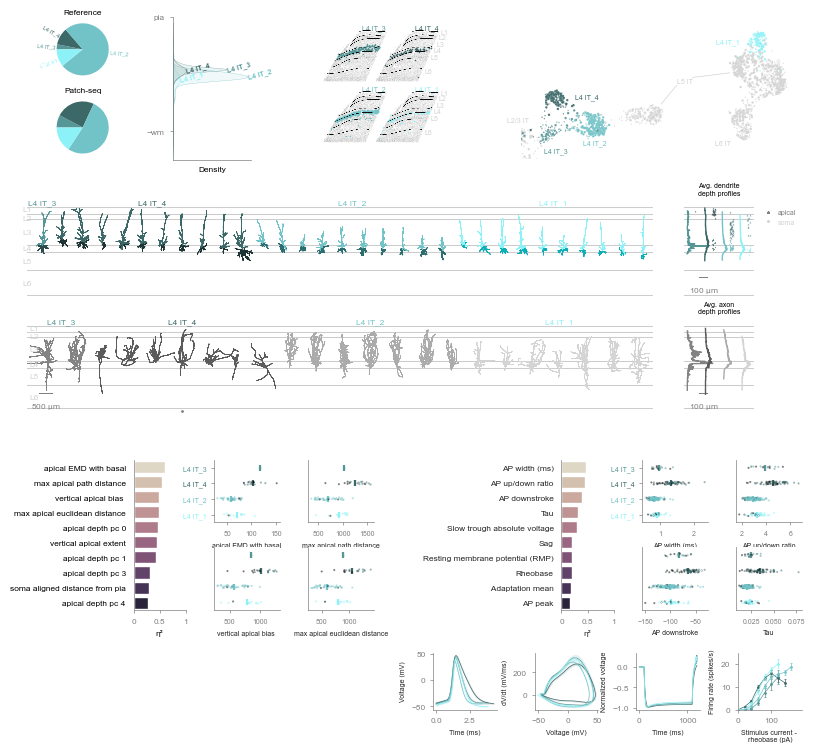

In [ ]:
#plot templates
for layer in ['L4']: #layers:

    subclasses = subclass_order_dict[layer]

    morph_plot_split = group_supertype_split[layer]

    output_file = os.path.join(output_dir, r'{}.pdf'.format(layer.replace(' ', '').replace('/', '-')))
    # if mark_paradigm:
    #     output_file = output_file.replace('.pdf', f'_markParadigm_{mark_paradigm_type}.pdf')

    fig = plt.figure(figsize=group_fig_size[layer])
    gs = gridspec.GridSpec(
        4, 1, height_ratios=group_height_ratios[layer], hspace=0.3, wspace=0.8)

    ttype_order = flatten([tx_order_dict[sub] for sub in subclasses if sub in tx_order_dict])
    morpho_ttype_order = [t for t in ttype_order if t in morpho_sorted_clean_data[morpho_sorted_clean_data['subclass_label'].isin(subclasses)].t_type.unique().tolist()]
    ephys_ttype_order = [t for t in ttype_order if t in ephys_sorted_clean_data[ephys_sorted_clean_data['subclass_label'].isin(subclasses)].t_type.unique().tolist()]

    gs_meta = gridspec.GridSpecFromSubplotSpec(
            2, 4,
            subplot_spec=gs[0],
            width_ratios=meta_ax_width_ratios[layer],
    )

    #reference abundance 
    layer_df = abundance_ref[abundance_ref['layer'] == layer]
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_meta[0,0]), color_dict, label_supertypes=True, radius=abundance_radius[layer], center=(-6, 0), title='Reference', label_threshold=0)

    #patch-seq abundance 
    layer_df = abundance_pseq[abundance_pseq[subclass_col].isin(subclasses)][cluster_col].value_counts(normalize=True).reset_index()
    layer_df.columns = ['supertype', 'supertype_frac_of_layer']
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_meta[1,0]), color_dict, label_supertypes=False, radius=abundance_radius[layer], center=(-6, -6), title='Patch-seq', title_bottom=False)

    if split_spatial_density[layer]:

        gs_spatial = gridspec.GridSpecFromSubplotSpec(
            2, 2,
            subplot_spec=gs_meta[:,1],
            wspace=0.5)
        
        spatial_axes = []
        for i, spatial_group in enumerate(split_spatial_groups[layer]):
            if i % 2 == 0:  label_y = True
            else:  label_y = False
            if i >= 2: label_x = True
            else: label_x = False

            this_spatial_ax = plt.subplot(gs_spatial[i])
            spatial_axes.append(this_spatial_ax)

            #spatial depth (isodepth) 
            layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'] == spatial_group]
            plot_spatial_density_kde(layer_isodepth_df, this_spatial_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], color_dict, label_peaks=True, label_y=label_y, label_x=label_x)

        # --- make all x axes share the same limits ---
        xmin = min(ax.get_xlim()[0] for ax in spatial_axes)
        xmax = max(ax.get_xlim()[1] for ax in spatial_axes)
        for ax in spatial_axes: ax.set_xlim(xmin, xmax)

    else:
        #spatial depth (isodepth) 
        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]
        plot_spatial_density_kde(layer_isodepth_df, plt.subplot(gs_meta[:,1]), 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], color_dict, label_peaks=True)

    #spatial slice
    plot_spatial_slice(spatial_slice_data, plt.subplot(gs_meta[:,-2]), ttype_order, color_dict, rot_deg=221, ncols=spatial_cols[layer], 
                       skip_subplot=skip_slice_subplot_idxs[layer], overlay_layers=True, overlay_path=spatial_slice_layer_overlay_file)

    #UMAP cropping
    reference_umap['color'] = reference_umap.apply(lambda row: color_dict[row['celltype']] if row['subclass'] in subclasses else 'lightgrey', axis=1)
    [(x_min, x_max), (y_min, y_max)] = ref_umap_axes_lims[layer]
    plot_ref_umap_crop(reference_umap, plt.subplot(gs_meta[:,-1]), x_min, x_max, y_min, y_max, SEAAD_COLORS, 
                   supertypes=ttype_order, label_dict=umap_labels[layer], line_list=umap_lines[layer],
                   legend_loc=umap_legend_locs[layer], legend_length=umap_legend_lengths[layer])

    #morphologies
    if axon_viewer[layer]:
        #plot one row of dendrite morphologies
        #AND one row of axon morphologies (not the same cells)

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            2, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer], plot_scalebar=False)

        ax_morph_bottom = plt.subplot(gs_morph[1, 0])
        plot_morph_lineup_swb( ax_morph_bottom, morpho_viewer_cells_axon[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer]+300, compartment_type = 'axon')

        #plot dendrite depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        profile_xoffets = plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order[:morph_plot_split], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

        if plot_apical_tips[layer]:
            #plot distal apical tips and somas
            plot_distal_apicals(ttype_apical_dict[layer], ttype_order, ax_profiles_top, profile_xoffets, ttype_apical_buffer_dict[layer], color_dict)

        ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_bottom.transAxes)
        ax_morph_bottom.sharey(ax_profiles_bottom)
        plot_axon_depth_profiles_swb(ax_profiles_bottom, morpho_data_axon, 't_type', morpho_ttype_order, aligned_histogram_axon, axon_cols, group_layer_edges[layer])
        ax_profiles_bottom.set_title("Avg. axon\ndepth profiles", fontsize=5)

    elif not morph_plot_split is None:
        #plot two rows of dendrite morphologies 

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            2, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[:morph_plot_split], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer], plot_scalebar=False)

        ax_morph_bottom = plt.subplot(gs_morph[1, 0])
        plot_morph_lineup_swb( ax_morph_bottom, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[morph_plot_split:], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])

        #plot dendrite depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order[:morph_plot_split], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer])
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

        ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_bottom.transAxes)
        ax_morph_bottom.sharey(ax_profiles_bottom)
        plot_dendrite_depth_profiles_swb(ax_profiles_bottom, morpho_sorted_clean_data, 't_type', morpho_ttype_order[morph_plot_split:], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer])

    else:
        #plot one row of dendrite morphologies 

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            1, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])
    
        #depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer])
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)


        # plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells_axon[layer], 't_type', morpho_ttype_order, 
        #                     layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], morph_spacing=group_morph_spacing[layer], compartment_type = 'axon')

        # plot_axon_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, axon_cols, group_layer_edges[layer])


    #Morpho & Ephys feature plots
    gs_feat_prop = gridspec.GridSpecFromSubplotSpec(
            2, 8,
            subplot_spec=gs[2],
            width_ratios=(1.2,0.8,1,1,2,0.8,1,1),
            hspace=0.4, wspace=0.4
    )
    #MORPHO
    #eta2

    if not morpho_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(morpho_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,1]), label_right=False)

    #get top four features 
    eta_squared_df = morpho_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 2 + (i % 2)]), morpho_ttype_order, morpho_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict)
        
    #EPHYS
    #eta2 
    if not ephys_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(ephys_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,5]), label_right=False)

    #get top four features 
    eta_squared_df = ephys_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 6 + (i % 2)]), ephys_ttype_order, ephys_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict, mark_paradigm=mark_paradigm, mark_paradigm_type=mark_paradigm_type)

        
    #EPHYS average trace plots 
    gs_ephys_trace = gridspec.GridSpecFromSubplotSpec(
            1, 8,
            subplot_spec=gs[3],
            width_ratios=(1,1,1,1,1,1,1,1),
            wspace=0.6
    )
    ephys_cluster_col = 'HANN_cluster_label_assignment_winner'

    # #rheobase (ap width)
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[4]), 'width')

    #AP phase plot 
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[5]), 'phase')

    #subthreshold response
    # subthresh_spike_data = np.load(os.path.join(ephys_subthresh_dir, 'subthreshold_data_{}.npy'.format(layer.replace('/','-').replace(' ', '_'))), allow_pickle=True)[()]
    # subthresh_metadata = pd.read_csv(os.path.join(ephys_subthresh_dir, 'subthreshold_metadata.csv'))
    plot_ephys_subthresh(plt.subplot(gs_ephys_trace[6]), subthresh_spike_data[layer], subthresh_metadata, ephys_ttype_order, ephys_cluster_col, color_dict)

    #FI curve
    fi_curve_ax = plt.subplot(gs_ephys_trace[7])
    plot_avg_fi_for_mets(fi_curve_ax, ephys_fi_data_formatted, 't_type', ephys_ttype_order, xlim=fi_xlim[layer], ylim=fi_ylim[layer])

    for ax in fig.get_axes():
        ax.spines['top'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0.5)
        ax.tick_params(axis='both', length=2, width=0.5)


    plt.savefig(output_file, bbox_inches="tight", dpi=1000)


# Layer 5, Layer 6

C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_17968\2644299183.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:503: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:521: UserWarning: set

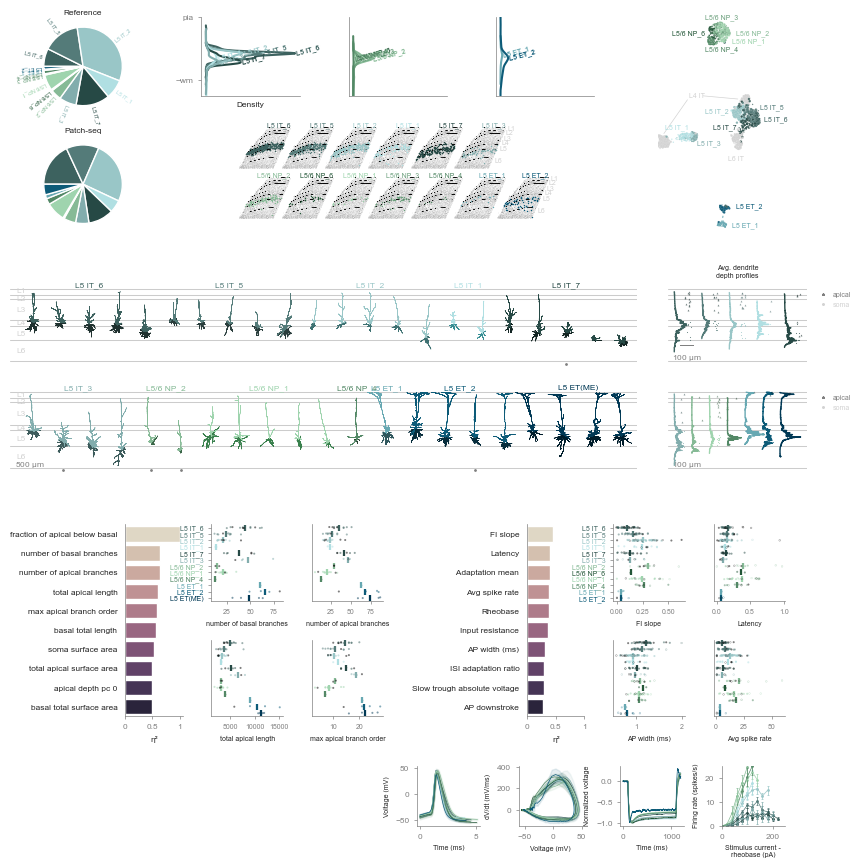

In [ ]:
#plot templates
for layer in ['L5', 'L6']: 

    subclasses = subclass_order_dict[layer]

    morph_plot_split = group_supertype_split[layer]

    output_file = os.path.join(output_dir, r'{}.pdf'.format(layer.replace(' ', '').replace('/', '-')))
    # if mark_paradigm:
    #     output_file = output_file.replace('.pdf', f'_markParadigm_{mark_paradigm_type}.pdf')

    fig = plt.figure(figsize=group_fig_size[layer])
    gs = gridspec.GridSpec(
        4, 1, height_ratios=group_height_ratios[layer], hspace=0.3, wspace=0.8)

    ttype_order = flatten([tx_order_dict[sub] for sub in subclasses if sub in tx_order_dict])
    morpho_ttype_order = [t for t in ttype_order if t in morpho_sorted_clean_data[morpho_sorted_clean_data['subclass_label'].isin(subclasses)].t_type.unique().tolist()]
    ephys_ttype_order = [t for t in ttype_order if t in ephys_sorted_clean_data[ephys_sorted_clean_data['subclass_label'].isin(subclasses)].t_type.unique().tolist()]

    gs_meta = gridspec.GridSpecFromSubplotSpec(
            1, 3,
            subplot_spec=gs[0],
            width_ratios=meta_ax_width_ratios[layer],
    )

    gs_abundance = gridspec.GridSpecFromSubplotSpec(
            2,1,
            subplot_spec=gs_meta[:,0]
    )

    #reference abundance 
    layer_df = abundance_ref[abundance_ref['layer'] == layer]
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_abundance[0]), color_dict, label_supertypes=True, radius=abundance_radius[layer], center=(-6, 0), title='Reference', label_threshold=0)

    #patch-seq abundance 
    layer_df = abundance_pseq[abundance_pseq[subclass_col].isin(subclasses)][cluster_col].value_counts(normalize=True).reset_index()
    layer_df.columns = ['supertype', 'supertype_frac_of_layer']
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_abundance[1]), color_dict, label_supertypes=False, radius=abundance_radius[layer], center=(-6, -6), title='Patch-seq', title_bottom=False)

    gs_spatial = gridspec.GridSpecFromSubplotSpec(
            2,1,
            subplot_spec=gs_meta[:,1], 
            height_ratios=[1, 1.5], 
            hspace=0.2
    )

    if split_spatial_density[layer]:

        gs_kde = gridspec.GridSpecFromSubplotSpec(
            1, len(split_spatial_groups[layer]),
            subplot_spec=gs_spatial[0],
            wspace=0.5)
        

        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]
        layer_kde_df = get_spatial_density_kde(layer_isodepth_df, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name',
                                            [t for t in TTYPE_ORDER if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], SEAAD_COLORS)

        spatial_axes = []
        for i, spatial_group in enumerate(split_spatial_groups[layer]):

            this_spatial_ax = plt.subplot(gs_kde[i])
            spatial_axes.append(this_spatial_ax)

            this_ttype_order = flatten([tx_order_dict[sub] for sub in [spatial_group] if sub in tx_order_dict])
            plot_precomputed_kde(this_spatial_ax, layer_kde_df, this_ttype_order, 
                                SEAAD_COLORS, label_x=i==0, label_y=i==0)

        # --- make all x axes share the same limits ---
        xmin = min(ax.get_xlim()[0] for ax in spatial_axes)
        xmax = max(ax.get_xlim()[1] for ax in spatial_axes)
        for ax in spatial_axes: ax.set_xlim(xmin, xmax)    
        
        # spatial_axes = []
        # for i, spatial_group in enumerate(split_spatial_groups[layer]):

        #     this_spatial_ax = plt.subplot(gs_kde[i])
        #     spatial_axes.append(this_spatial_ax)

        #     #spatial depth (isodepth) 
        #     layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'] == spatial_group]
        #     plot_spatial_density_kde(layer_isodepth_df, this_spatial_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
        #                         [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], color_dict, label_peaks=True, label_y=i==0, label_x=i==0, common_norm=False)
        #     #scale the dspatial density plot by it's weight (proportion of the full dataset) so that

        # # --- make all x axes share the same limits ---
        # xmin = min(ax.get_xlim()[0] for ax in spatial_axes)
        # xmax = max(ax.get_xlim()[1] for ax in spatial_axes)
        # for ax in spatial_axes: ax.set_xlim(xmin, xmax)

    else:
        #spatial depth (isodepth) 
        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]
        plot_spatial_density_kde(layer_isodepth_df, plt.subplot(gs_spatial[0]), 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], color_dict, label_peaks=True)

    #spatial slice
    slice_ax = plt.subplot(gs_spatial[1])
    plot_spatial_slice(spatial_slice_data, slice_ax, ttype_order, color_dict, rot_deg=221, ncols=spatial_cols[layer], skip_subplot=skip_slice_subplot_idxs[layer], 
                       overlay_layers=True, overlay_path=spatial_slice_layer_overlay_file)
    # slice_ax.set_xlim((0, 35000))

    #UMAP cropping
    reference_umap['color'] = reference_umap.apply(lambda row: color_dict[row['celltype']] if row['subclass'] in subclasses else 'lightgrey', axis=1)
    [(x_min, x_max), (y_min, y_max)] = ref_umap_axes_lims[layer]
    plot_ref_umap_crop(reference_umap, plt.subplot(gs_meta[:,2]), x_min, x_max, y_min, y_max, SEAAD_COLORS, 
                   supertypes=ttype_order, label_dict=umap_labels[layer], line_list=umap_lines[layer],
                   legend_loc=umap_legend_locs[layer], legend_length=umap_legend_lengths[layer])

    #morphologies
    if axon_viewer[layer]:
        #plot one row of dendrite morphologies
        #AND one row of axon morphologies (not the same cells)

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            2, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer], plot_scalebar=False)

        ax_morph_bottom = plt.subplot(gs_morph[1, 0])
        plot_morph_lineup_swb( ax_morph_bottom, morpho_viewer_cells_axon[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer]+400, compartment_type = 'axon')

        #plot dendrite depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        profile_xoffets = plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order[:morph_plot_split], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

        if plot_apical_tips[layer]:
            #plot distal apical tips and somas
            plot_distal_apicals(ttype_apical_dict[layer], ttype_order, ax_profiles_top, profile_xoffets, ttype_apical_buffer_dict[layer], color_dict)

        ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_bottom.transAxes)
        ax_morph_bottom.sharey(ax_profiles_bottom)
        plot_axon_depth_profiles_swb(ax_profiles_bottom, morpho_data_axon, 't_type', morpho_ttype_order, aligned_histogram_axon, axon_cols, group_layer_edges[layer])
        ax_profiles_bottom.set_title("Avg. axon\ndepth profiles", fontsize=5)

    elif not morph_plot_split is None:
        #plot two rows of dendrite morphologies 

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            2, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[:morph_plot_split], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer], plot_scalebar=False)

        ax_morph_bottom = plt.subplot(gs_morph[1, 0])
        plot_morph_lineup_swb( ax_morph_bottom, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[morph_plot_split:], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])

        #plot dendrite depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.222, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        profile_xoffets = plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order[:morph_plot_split], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

        if plot_apical_tips[layer]:
            #plot distal apical tips and somas
            plot_distal_apicals(ttype_apical_dict[layer], morpho_ttype_order[:morph_plot_split], ax_profiles_top, profile_xoffets, ttype_apical_buffer_dict[layer], color_dict)

        ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.222, 1], transform=ax_morph_bottom.transAxes)
        ax_morph_bottom.sharey(ax_profiles_bottom)
        profile_xoffets = plot_dendrite_depth_profiles_swb(ax_profiles_bottom, morpho_sorted_clean_data, 't_type', morpho_ttype_order[morph_plot_split:], aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)

        if plot_apical_tips[layer]:
            #plot distal apical tips and somas
            plot_distal_apicals(ttype_apical_dict[layer],  morpho_ttype_order[morph_plot_split:], ax_profiles_bottom, profile_xoffets, ttype_apical_buffer_dict[layer], color_dict)

    else:
        #plot one row of dendrite morphologies 

        # Morphology layer plots
        gs_morph = gridspec.GridSpecFromSubplotSpec(
            1, 2,
            subplot_spec=gs[1],
            width_ratios=(8, 1),
        )

        ax_morph_top = plt.subplot(gs_morph[0, 0])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])
    
        #depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.111, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)


        # plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells_axon[layer], 't_type', morpho_ttype_order, 
        #                     layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], morph_spacing=group_morph_spacing[layer], compartment_type = 'axon')

        # plot_axon_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, axon_cols, group_layer_edges[layer])


    #Morpho & Ephys feature plots
    gs_feat_prop = gridspec.GridSpecFromSubplotSpec(
            2, 8,
            subplot_spec=gs[2],
            width_ratios=(1.2,0.8,1,1,
                          1.2,0.8,1,1),
            hspace=0.5, wspace=0.4
    )
    #MORPHO
    #eta2

    if not morpho_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(morpho_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,1]), label_right=False)

    #get top four features 
    eta_squared_df = morpho_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    # top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    top_features = (eta_squared_df[~eta_squared_df.feature.isin(morpho_feature_skip[layer])].sort_values('abs_eta_squared', ascending=False).feature.iloc[:n_features].tolist())
    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 2 + (i % 2)]), morpho_ttype_order, morpho_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict)
        
    #EPHYS
    #eta2 
    if not ephys_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(ephys_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,5]), label_right=False)

    #get top four features 
    eta_squared_df = ephys_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    top_features = [ephys_feature_swap[layer].get(x, x) for x in top_features]


    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 6 + (i % 2)]), ephys_ttype_order, ephys_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict, mark_paradigm=mark_paradigm, mark_paradigm_type=mark_paradigm_type)

        
    #EPHYS average trace plots 
    gs_ephys_trace = gridspec.GridSpecFromSubplotSpec(
            1, 8,
            subplot_spec=gs[3],
            width_ratios=(1,1,1,1,1,1,1,1),
            wspace=0.6
    )
    ephys_cluster_col = 'HANN_cluster_label_assignment_winner'

    # #rheobase (ap width)
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[4]), 'width')

    #AP phase plot 
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[5]), 'phase')

    #subthreshold response
    # subthresh_spike_data = np.load(os.path.join(ephys_subthresh_dir, 'subthreshold_data_{}.npy'.format(layer.replace('/','-').replace(' ', '_'))), allow_pickle=True)[()]
    # subthresh_metadata = pd.read_csv(os.path.join(ephys_subthresh_dir, 'subthreshold_metadata.csv'))
    plot_ephys_subthresh(plt.subplot(gs_ephys_trace[6]), subthresh_spike_data[layer], subthresh_metadata, ephys_ttype_order, ephys_cluster_col, color_dict)

    #FI curve
    fi_curve_ax = plt.subplot(gs_ephys_trace[7])
    plot_avg_fi_for_mets(fi_curve_ax, ephys_fi_data_formatted, 't_type', ephys_ttype_order, xlim=fi_xlim[layer], ylim=fi_ylim[layer])

    for ax in fig.get_axes():
        ax.spines['top'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0.5)
        ax.tick_params(axis='both', length=2, width=0.5)


    plt.savefig(output_file, bbox_inches="tight", dpi=1000)


# Layer 2, Layer 3

### Analysis

Morpho Viewer

In [19]:
layers = ['L2', 'L3']

layer_num_cells_per_ttype['L2'] = 6
layer_num_cells_per_ttype['L3'] = 5

In [20]:
#prep for viewer section
# num_cells_per_ttype = 5

morpho_viewer_cells = {}
for layer in layers:
    sorted_cells_ttype = morpho_sorted_clean_data[morpho_sorted_clean_data['layer_split'] == layer]

    def sample_representative(group, n=layer_num_cells_per_ttype[layer]):
        teml_cells = group[group['lobe'] == 'TemL'].sort_values('soma_distance_from_pia')

        # Helper function: evenly sample across soma depth
        def even_sample(df, n):
            if len(df) <= n:
                return df
            return df.iloc[np.linspace(0, len(df) - 1, n, dtype=int)]

        if len(teml_cells) >= n:
            sampled = even_sample(teml_cells, n)
        else:
            # Take all TemL cells
            sampled = teml_cells.copy()
            remaining = n - len(sampled)

            other_cells = group[group['lobe'] != 'TemL'].sort_values('soma_distance_from_pia')
            sampled_others = even_sample(other_cells, remaining)
            sampled = pd.concat([sampled, sampled_others], ignore_index=True)

        return sampled

    temp = (
        sorted_cells_ttype
        .reset_index()
        .groupby('t_type', group_keys=False)
        .apply(sample_representative)
        .reset_index(drop=True)
    )

    temp['t_type'] = pd.Categorical(temp['t_type'], categories=TTYPE_ORDER, ordered=True)

    # sort by t_type and soma depth for final order
    morpho_viewer_cells[layer] = temp.sort_values(by=['t_type', 'soma_distance_from_pia'])


Morpho Eta2 and FDR corrected KW of ttypes within each subclass

In [21]:
features = raw_feature_wide.columns.tolist()[1:]

# subclass x feature stats
group_var = 'layer_split'
group_var_order = layers

morpho_eta_squared_group = dict()
morpho_kw_pvals_fdr_group = dict()
morpho_dunn_pvals_fdr_group = dict()

for group in group_var_order:
    print(group)
    group_data = morpho_sorted_clean_data.loc[morpho_sorted_clean_data[group_var] == group]

    # Get t-types in the current group
    x_var = 't_type'
    x_var_order = [t for t in TTYPE_ORDER if t in group_data[x_var].unique()]

    # Initialize dictionaries for Kruskal-Wallis H test and p-values
    kw_hvals = dict()
    kw_pvals = dict()

    # Iterate over features to calculate KW test and eta-squared
    for f in features:
        # Get groups of data for each t-type
        t_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

        # Only include non-empty groups with at least 1 cell
        t_groups = [g for g in t_groups if len(g) >= 1]

        if len(t_groups) < 2:
            print(f"Not enough t_groups with data for feature {f}")
            continue

        try:
            hvalue, pvalue = stats.kruskal(*t_groups, nan_policy='omit')
            kw_hvals[f] = hvalue
            kw_pvals[f] = pvalue
        except ValueError as e:
            print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

    # FDR correction for KW p-values
    kw_pvals_list = list(kw_pvals.values())
    kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

    kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
    kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

    # Post-hoc Dunn test for significant KW features (after FDR correction)
    dunn_pvals_fdr = dict()
    for k, v in kw_rejected.items():
        if v:  # only if null hypothesis was rejected
            dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

    # Calculate eta-squared for the KW H-test
    eta_squared_ttypes = {}
    k = len(t_groups)  # number of t-types (groups)
    n = sum([len(g) for g in t_groups])  # total number of observations
    print(f'k: {k}, n: {n}')
    for f, h in kw_hvals.items():
        esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
        eta_squared_ttypes[f] = esq

    eta_squared_ttypes_df = pd.DataFrame.from_dict(sorted(eta_squared_ttypes.items(), key=operator.itemgetter(1), reverse=True))
    eta_squared_ttypes_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

    # Store results
    morpho_eta_squared_group[group] = eta_squared_ttypes_df
    morpho_kw_pvals_fdr_group[group] = kw_pvals_fdr
    morpho_dunn_pvals_fdr_group[group] = dunn_pvals_fdr


L2
Kruskal-Wallis not calculated for fraction of apical below basal because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for fraction of basal above apical because of an error: All numbers are identical in kruskal
k: 4, n: 90
L3
Kruskal-Wallis not calculated for fraction of apical below basal because of an error: All numbers are identical in kruskal
Kruskal-Wallis not calculated for fraction of basal above apical because of an error: All numbers are identical in kruskal
k: 6, n: 49


Ephys Eta2 and FDR corrected KW of ttypes within each subclass

In [22]:
#Exclude the two features where < 25% of cells have a value
exclude_features = ['Chirp peak','ZAP (peak impedance)']
features = [f for f in ephys_feature_cols if f not in exclude_features]

# subclass x feature stats
group_var = 'layer_split'
group_var_order = layers

ephys_eta_squared_group = dict()
ephys_kw_pvals_fdr_group = dict()
ephys_dunn_pvals_fdr_group = dict()

for group in group_var_order:
    print(group)
    group_data = ephys_sorted_clean_data.loc[ephys_sorted_clean_data[group_var] == group]

    if acute_only:
        group_data = group_data[group_data.paradigm == 'acute']


    # Get t-types in the current subclass
    x_var = 't_type'
    x_var_order = [t for t in TTYPE_ORDER if t in group_data[x_var].unique()]

    # Initialize dictionaries for Kruskal-Wallis H test and p-values
    kw_hvals = dict()
    kw_pvals = dict()

    # Iterate over features to calculate KW test and eta-squared
    for f in features:
        # Get groups of data for each t-type
        t_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

        # Only include non-empty groups with at least 1 cell
        t_groups = [g for g in t_groups if len(g) >= 1]

        if len(t_groups) < 2:
            print(f"Not enough groups with data for feature {f}")
            continue

        try:
            hvalue, pvalue = stats.kruskal(*t_groups, nan_policy='omit')
            kw_hvals[f] = hvalue
            kw_pvals[f] = pvalue
        except ValueError as e:
            print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

    # FDR correction for KW p-values
    kw_pvals_list = list(kw_pvals.values())
    kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

    kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
    kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

    # Post-hoc Dunn test for significant KW features (after FDR correction)
    dunn_pvals_fdr = dict()
    for k, v in kw_rejected.items():
        if v:  # only if null hypothesis was rejected
            dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

    # Calculate eta-squared for the KW H-test
    eta_squared_ttypes = {}
    k = len(t_groups)  # number of t-types (t_groups)
    n = sum([len(g) for g in t_groups])  # total number of observations
    print(f'k: {k}, n: {n}')
    for f, h in kw_hvals.items():
        esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
        eta_squared_ttypes[f] = esq

    eta_squared_ttypes_df = pd.DataFrame.from_dict(sorted(eta_squared_ttypes.items(), key=operator.itemgetter(1), reverse=True))
    eta_squared_ttypes_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

    # Store results
    ephys_eta_squared_group[group] = eta_squared_ttypes_df
    ephys_kw_pvals_fdr_group[group] = kw_pvals_fdr
    ephys_dunn_pvals_fdr_group[group] = dunn_pvals_fdr


L2
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 4, n: 245
L3
Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 6, n: 134


L2, L3 plots - new layer groups (L2/3 IT_2 is L2)

In [23]:
group_supertype_split['L2'] = 2
group_supertype_split['L3'] = 3

group_spatial_kde_split = {
    'L2' : None, 
    'L3' : 3
}

group_fig_size['L2'] = (13, 9)
group_fig_size['L3'] = (13, 9)

group_height_ratios['L2'] = (3, 2, 1)
group_height_ratios['L3'] = (3, 2, 1)

meta_ax_width_ratios['L2'] = (0.7, 1.5, 1, 0.8, 3.4)
meta_ax_width_ratios['L3'] = (0.7, 1.5, 1, 0.8, 3.4)

abundance_radius['L2'] = 1
abundance_radius['L3'] = 1

spatial_cols['L2'] = 2
spatial_cols['L3'] = 2

ref_umap_axes_lims['L2'] = [(-12.5, -7), (-8.5, 2)]
ref_umap_axes_lims['L3'] = [(-12.5, -7), (-8.5, 2)]

umap_labels['L2'] = {'L2 IT_6': {'x': -12.5, 'y': -4.5, 'ha': 'right', 'va': 'center'},
                     'L2 IT_1': {'x': -10, 'y': -7.5, 'ha': 'right', 'va': 'center'},
                     'L2 IT_7': {'x': -12.5, 'y': -3.5, 'ha': 'right', 'va': 'center'},
                     'L2 IT_2': {'x': -8, 'y': -8, 'ha': 'left', 'va': 'center'}}
umap_labels['L3'] = {'L3 IT_8': {'x': -12.5, 'y': -6, 'ha': 'right', 'va': 'center'},
                     'L3 IT_12': {'x': -12, 'y': -2.5, 'ha': 'right', 'va': 'center'},
                     'L3 IT_10': {'x': -9, 'y': -3, 'ha': 'left', 'va': 'center'},
                     'L3 IT_13': {'x': -8.5, 'y': -2, 'ha': 'left', 'va': 'center'},
                     'L3 IT_5': {'x': -8.5, 'y': -1, 'ha': 'left', 'va': 'center'},
                     'L3 IT_3': {'x': -11, 'y': 1, 'ha': 'right', 'va': 'center'}}

umap_lines['L2'] = []
umap_lines['L3'] = []

umap_legend_locs['L2'] = None
umap_legend_locs['L3'] = None

umap_legend_lengths['L2'] = 1
umap_legend_lengths['L3'] = 1

group_layer_edges['L2'] = [0, 247.9338740595, 410.0775480852, 1322.3048788711]
group_layer_edges['L3'] = [0, 247.9338740595, 410.0775480852, 1322.3048788711, 1557.8034331092]

group_layer_labels['L2'] = {'L1': 123.96693702975, 'L2': 329.00571107235, 'L3': 866.1912134781501}
group_layer_labels['L3'] = {'L1': 123.96693702975, 'L2': 329.00571107235, 'L3': 866.1912134781501, 'L4': 1440.0541559901499}

group_morph_spacing['L2'] = 600
group_morph_spacing['L3'] = 600

fi_ylim['L2'] = (0, 10)
fi_ylim['L3'] = (0, 25)


L2


C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21664\2080151070.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:503: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:521: UserWarning: set

L3


C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21664\2080151070.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:503: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:521: UserWarning: set

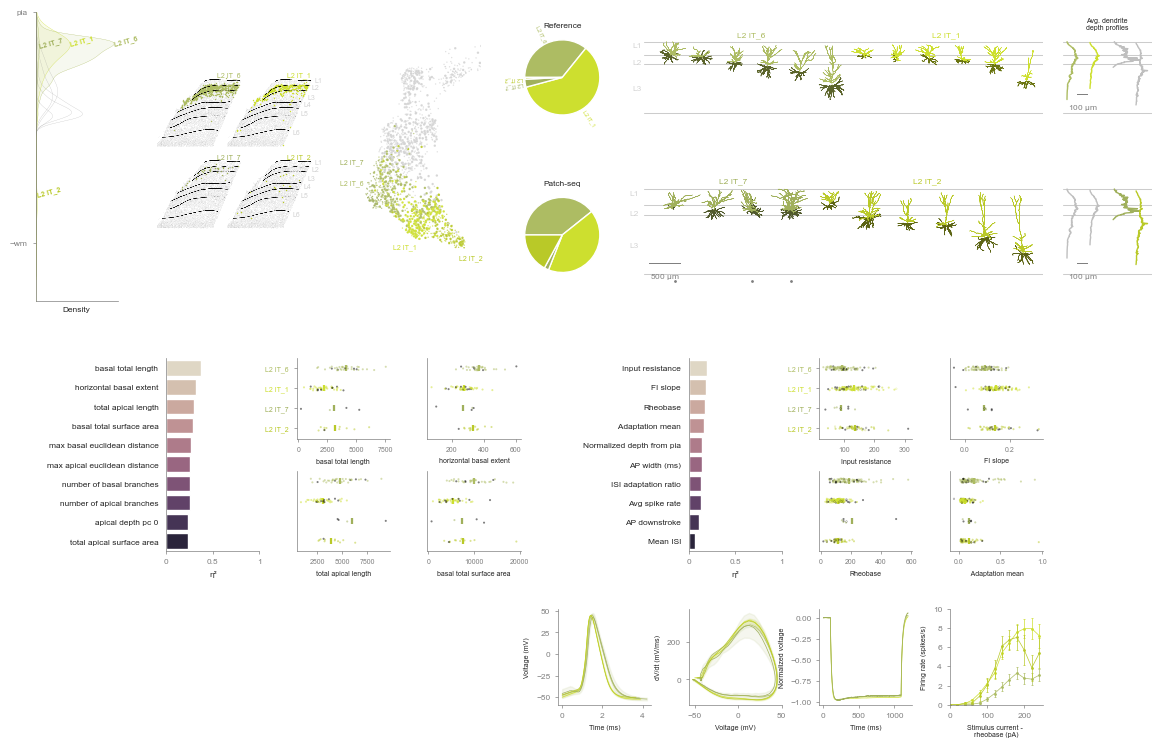

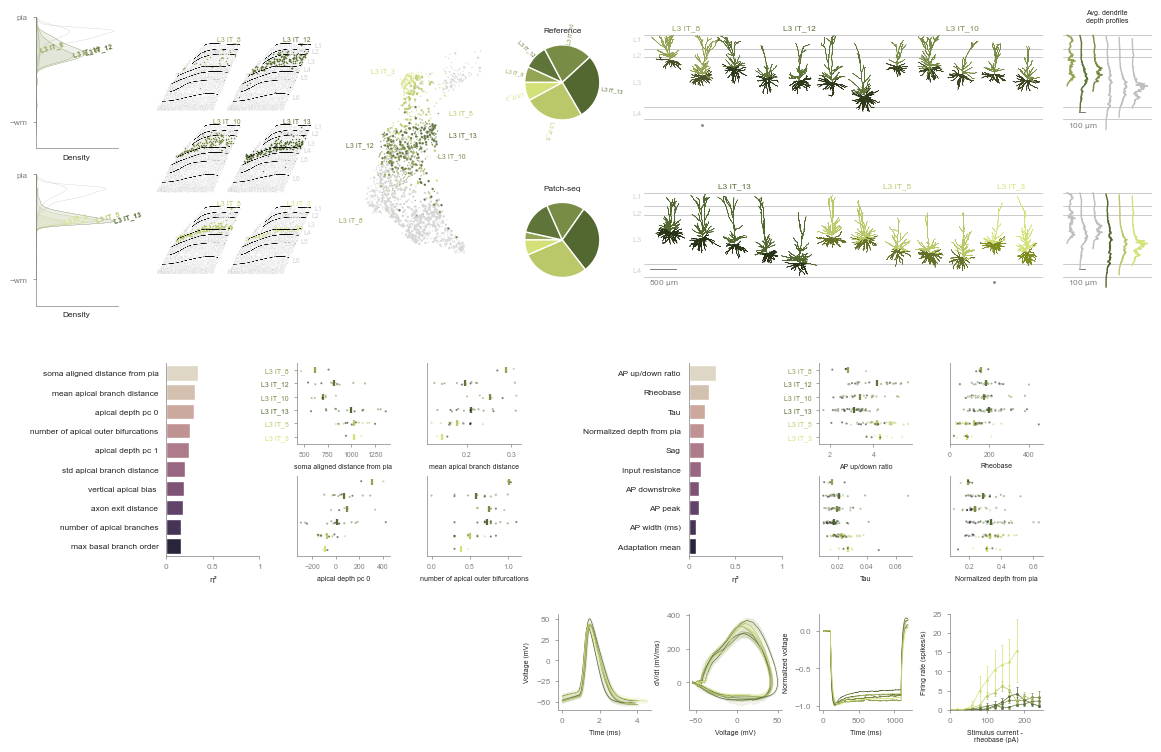

In [ ]:
for layer in ['L2', 'L3']:
    print(layer)

    ttypes = [t for t in ttype_to_layer_dict.keys() if ttype_to_layer_dict[t] == layer.replace('L', 'Layer ')]

    morph_plot_split = group_supertype_split[layer]
    kde_plot_split = group_spatial_kde_split[layer]

    output_file = os.path.join(output_dir, r'{}.pdf'.format(layer.replace(' ', '').replace('/', '-')))
    # if mark_paradigm:
    #     output_file = output_file.replace('.pdf', f'_markParadigm_{mark_paradigm_type}.pdf')


    fig = plt.figure(figsize=group_fig_size[layer])
    gs = gridspec.GridSpec(
        3, 1, height_ratios=group_height_ratios[layer], hspace=0.3, wspace=0.8)

    ttype_order = [t for t in TTYPE_ORDER if t in ttypes]
    morpho_ttype_order = [t for t in ttype_order if t in morpho_sorted_clean_data.t_type.unique().tolist()]
    ephys_ttype_order = [t for t in ttype_order if t in ephys_sorted_clean_data.t_type.unique().tolist()]

    gs_meta = gridspec.GridSpecFromSubplotSpec(
            2, 5,
            subplot_spec=gs[0],
            width_ratios=meta_ax_width_ratios[layer],
    )

    if not kde_plot_split is None: 

        #Top plot
        #spatial depth (isodepth) 
        #plot this layer in color with fill
        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(ttypes[:kde_plot_split])]
        spatial_density_ax = plt.subplot(gs_meta[0,0])
        plot_spatial_density_kde(layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                color_dict, label_peaks=True)
        #plot other layer in grey no fill 
        if layer == 'L2': other_layer = 'L3'
        else: other_layer = 'L2'
        other_layer_ttypes = [t for t in ttype_to_layer_dict.keys() if ttype_to_layer_dict[t] == other_layer.replace('L', 'Layer ')]
        other_layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(other_layer_ttypes)]
        plot_spatial_density_kde(other_layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in other_layer_ttypes if t in other_layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                {k: 'grey' for k in other_layer_ttypes}, label_peaks=False, fill=False, alpha=0.5)

        #Bottom plot
        #spatial depth (isodepth) 
        #plot this layer in color with fill
        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(ttypes[kde_plot_split:])]
        spatial_density_ax = plt.subplot(gs_meta[1,0])
        plot_spatial_density_kde(layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                color_dict, label_peaks=True)
        #plot other layer in grey no fill 
        if layer == 'L2': other_layer = 'L3'
        else: other_layer = 'L2'
        other_layer_ttypes = [t for t in ttype_to_layer_dict.keys() if ttype_to_layer_dict[t] == other_layer.replace('L', 'Layer ')]
        other_layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(other_layer_ttypes)]
        plot_spatial_density_kde(other_layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in other_layer_ttypes if t in other_layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                {k: 'grey' for k in other_layer_ttypes}, label_peaks=False, fill=False, alpha=0.5)

    else: 
        #spatial depth (isodepth) 
        #plot this layer in color with fill
        layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(ttypes)]
        spatial_density_ax = plt.subplot(gs_meta[:,0])
        plot_spatial_density_kde(layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                color_dict, label_peaks=True)
        #plot other layer in grey no fill 
        if layer == 'L2': other_layer = 'L3'
        else: other_layer = 'L2'
        other_layer_ttypes = [t for t in ttype_to_layer_dict.keys() if ttype_to_layer_dict[t] == other_layer.replace('L', 'Layer ')]
        other_layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Supertype_name'].isin(other_layer_ttypes)]
        plot_spatial_density_kde(other_layer_isodepth_df, spatial_density_ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                [t for t in other_layer_ttypes if t in other_layer_isodepth_df.SEAAD_Supertype_name.unique()], 
                                {k: 'grey' for k in other_layer_ttypes}, label_peaks=False, fill=False, alpha=0.5)

    #spatial slice
    plot_spatial_slice(spatial_slice_data, plt.subplot(gs_meta[:,1]), ttype_order, color_dict, rot_deg=221, ncols=spatial_cols[layer], 
                       overlay_layers=True, overlay_path=spatial_slice_layer_overlay_file)

    #UMAP cropping
    reference_umap['color'] = reference_umap.apply(lambda row: color_dict[row['celltype']] if row['celltype'] in ttypes else 'lightgrey', axis=1)
    [(x_min, x_max), (y_min, y_max)] = ref_umap_axes_lims[layer]
    plot_ref_umap_crop(reference_umap, plt.subplot(gs_meta[:,2]), x_min, x_max, y_min, y_max, SEAAD_COLORS, 
                   supertypes=ttype_order, label_dict=umap_labels[layer], line_list=umap_lines[layer],
                   legend_loc=umap_legend_locs[layer], legend_length=umap_legend_lengths[layer])
    
    #reference abundance 
    layer_df = abundance_ref[abundance_ref['supertype'].isin(ttypes)]
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_meta[0,3]), color_dict, label_supertypes=True, radius=abundance_radius[layer], center=(-6, 0), title='Reference', label_threshold=0)

    #patch-seq abundance 
    layer_df = abundance_pseq[abundance_pseq[cluster_col].isin(ttypes)][cluster_col].value_counts(normalize=True).reset_index()
    layer_df.columns = ['supertype', 'supertype_frac_of_layer']
    layer_df['supertype'] = pd.Categorical(layer_df['supertype'], categories=ttype_order, ordered=True)
    layer_df = layer_df.sort_values('supertype')
    plot_abundance(layer_df, plt.subplot(gs_meta[1,3]), color_dict, label_supertypes=False, radius=abundance_radius[layer], center=(-6, -6), title='Patch-seq', title_bottom=False)

    #morphologies
    if not morph_plot_split is None:
        #plot two rows of morphologies 

        ax_morph_top = plt.subplot(gs_meta[0, 4])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[:morph_plot_split], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer], plot_scalebar=False)
        
        #depth profiles - plot all together on the bottom row 
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.222, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], {k: (color_dict[k] if k in morpho_ttype_order[:morph_plot_split] else '#bfbfbf') for k in ttypes})
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

        ax_morph_bottom = plt.subplot(gs_meta[1, 4])
        plot_morph_lineup_swb( ax_morph_bottom, morpho_viewer_cells[layer], 't_type', morpho_ttype_order[morph_plot_split:], 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])

        #depth profiles - plot all together on the bottom row 
        ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.222, 1], transform=ax_morph_bottom.transAxes)
        ax_morph_bottom.sharey(ax_profiles_bottom)
        plot_dendrite_depth_profiles_swb(ax_profiles_bottom, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], {k: (color_dict[k] if k in morpho_ttype_order[morph_plot_split:] else '#bfbfbf') for k in ttypes})
        # ax_profiles_bottom.set_title("Avg. dendrite\ndepth profiles", fontsize=5)

    else:
        #plot one frow of morphologies 

        ax_morph_top = plt.subplot(gs_meta[:, 4])
        plot_morph_lineup_swb(ax_morph_top, morpho_viewer_cells[layer], 't_type', morpho_ttype_order, 
                            layer_aligned_dir, group_layer_edges[layer], group_layer_labels[layer], SEAAD_COLORS, morph_spacing=group_morph_spacing[layer])

        #depth profiles
        ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.222, 1], transform=ax_morph_top.transAxes)
        ax_morph_top.sharey(ax_profiles_top)
        plot_dendrite_depth_profiles_swb(ax_profiles_top, morpho_sorted_clean_data, 't_type', morpho_ttype_order, aligned_histogram, basal_cols, apical_cols, group_layer_edges[layer], SEAAD_COLORS)
        ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)



    #Morpho & Ephys feature plots
    gs_feat_prop = gridspec.GridSpecFromSubplotSpec(
            2, 8,
            subplot_spec=gs[1],
            width_ratios=(1,1,1,1,1,1,1,1),
            hspace=0.4, wspace=0.4
    )
    #MORPHO
    #eta2

    if not morpho_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(morpho_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,1]), label_right=False)

    #get top four features 
    eta_squared_df = morpho_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 2 + (i % 2)]), morpho_ttype_order, morpho_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict)
        
    #EPHYS
    #eta2 
    if not ephys_eta_squared_group[layer].empty:
        plot_subclass_eta2_topn(ephys_eta_squared_group[layer], plt.subplot(gs_feat_prop[:,5]), label_right=False)

    #get top four features 
    eta_squared_df = ephys_eta_squared_group[layer]
    eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
    n_features = 4
    top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
    for i, feature in enumerate(top_features):
        plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 6 + (i % 2)]), ephys_ttype_order, ephys_sorted_clean_data, "t_type", feature, feature, 
                               show_yticklabels=(i==0), color_column="t_type_teml", color_dict=color_dict, mark_paradigm=mark_paradigm, mark_paradigm_type=mark_paradigm_type)

        
    #EPHYS average trace plots 
    gs_ephys_trace = gridspec.GridSpecFromSubplotSpec(
            1, 8,
            subplot_spec=gs[2],
            width_ratios=(1,1,1,1,1,1,1,1),
            wspace=0.4
    )
    ephys_cluster_col = 'HANN_cluster_label_assignment_winner'

    # #rheobase (ap width)
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[4]), 'width')

    #AP phase plot 
    plot_ap_ttype(ephys_ap_dict, ephys_ttype_order, ttype_to_subclass_dict, color_dict, plt.subplot(gs_ephys_trace[5]), 'phase')
    plot_ephys_subthresh(plt.subplot(gs_ephys_trace[6]), subthresh_spike_data[layer], subthresh_metadata, ephys_ttype_order, ephys_cluster_col, color_dict)

    #FI curve
    fi_curve_ax = plt.subplot(gs_ephys_trace[7])
    plot_avg_fi_for_mets(fi_curve_ax, ephys_fi_data_formatted, 't_type', ephys_ttype_order, ylim=fi_ylim[layer], color_dict=SEAAD_COLORS)

    for ax in fig.get_axes():
        ax.spines['top'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0.5)
        ax.tick_params(axis='both', length=2, width=0.5)


    plt.savefig(output_file, bbox_inches="tight", dpi=1000)


# Subclass Templates

### Analysis 

Morpho Eta2 and FDR corrected KW of ttypes within each subclass

In [43]:
features = raw_feature_wide.columns.tolist()[1:]

group_data = morpho_sorted_clean_data 

# Get subclasses
x_var = 'subclass_label'
x_var_order =  list(tx_order_dict.keys())

# Initialize dictionaries for Kruskal-Wallis H test and p-values
kw_hvals = dict()
kw_pvals = dict()

# Iterate over features to calculate KW test and eta-squared
for f in features:
    # Get groups of data for each subclass
    s_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

    # Only include non-empty groups with at least 1 cell
    s_groups = [g for g in s_groups if len(g) >= 1]

    if len(s_groups) < 2:
        print(f"Not enough s_groups with data for feature {f}")
        continue

    try:
        hvalue, pvalue = stats.kruskal(*s_groups, nan_policy='omit')
        kw_hvals[f] = hvalue
        kw_pvals[f] = pvalue
    except ValueError as e:
        print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

# FDR correction for KW p-values
kw_pvals_list = list(kw_pvals.values())
kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

# Post-hoc Dunn test for significant KW features (after FDR correction)
dunn_pvals_fdr = dict()
for k, v in kw_rejected.items():
    if v:  # only if null hypothesis was rejected
        dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

# Calculate eta-squared for the KW H-test
eta_squared_subclasses = {}
k = len(s_groups)  # number of t-types (groups)
n = sum([len(g) for g in s_groups])  # total number of observations
print(f'k: {k}, n: {n}')
for f, h in kw_hvals.items():
    esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
    eta_squared_subclasses[f] = esq

eta_squared_subclasses_df = pd.DataFrame.from_dict(sorted(eta_squared_subclasses.items(), key=operator.itemgetter(1), reverse=True))
eta_squared_subclasses_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

# Store results
morpho_eta_squared_subclass = eta_squared_subclasses_df
morpho_kw_pvals_fdr_subclass = kw_pvals_fdr
morpho_dunn_pvals_fdr_subclass = dunn_pvals_fdr


k: 9, n: 319


Ephys Eta2 and FDR corrected KW of ttypes within each subclass

In [44]:
#Exclude the two features where < 25% of cells have a value
exclude_features = ['Chirp peak','ZAP (peak impedance)']
features = [f for f in ephys_feature_cols if f not in exclude_features]

group_data = ephys_sorted_clean_data 

# Get subclasses
x_var = 'subclass_label'
x_var_order =  list(tx_order_dict.keys())

# Initialize dictionaries for Kruskal-Wallis H test and p-values
kw_hvals = dict()
kw_pvals = dict()

# Iterate over features to calculate KW test and eta-squared
for f in features:
    # Get groups of data for each subclass
    s_groups = [group_data.loc[group_data[x_var] == x][f].dropna() for x in x_var_order]

    if acute_only:
        s_groups = s_groups[s_groups.paradigm == 'acute']

    # Only include non-empty groups with at least 1 cell
    s_groups = [g for g in s_groups if len(g) >= 1]

    if len(s_groups) < 2:
        print(f"Not enough groups with data for feature {f}")
        continue

    try:
        hvalue, pvalue = stats.kruskal(*s_groups, nan_policy='omit')
        kw_hvals[f] = hvalue
        kw_pvals[f] = pvalue
    except ValueError as e:
        print(f'Kruskal-Wallis not calculated for {f} because of an error: {e}')

# FDR correction for KW p-values
kw_pvals_list = list(kw_pvals.values())
kw_rejected_list, kw_pvals_fdr_list = fdrcorrection(kw_pvals_list, alpha=0.05, method='indep', is_sorted=False)

kw_pvals_fdr = dict(zip(list(kw_pvals.keys()), kw_pvals_fdr_list))
kw_rejected = dict(zip(list(kw_pvals.keys()), kw_rejected_list))

# Post-hoc Dunn test for significant KW features (after FDR correction)
dunn_pvals_fdr = dict()
for k, v in kw_rejected.items():
    if v:  # only if null hypothesis was rejected
        dunn_pvals_fdr[k] = posthoc_dunn(group_data[group_data[x_var].isin(x_var_order)], val_col=k, group_col=x_var, p_adjust='fdr_bh', sort=True)

# Calculate eta-squared for the KW H-test
eta_squared_subclasses = {}
k = len(s_groups)  # number of t-types (t_groups)
n = sum([len(g) for g in s_groups])  # total number of observations
print(f'k: {k}, n: {n}')
for f, h in kw_hvals.items():
    esq = (h - k + 1) / (n - k)  # eta^2 formula for KW test
    eta_squared_subclasses[f] = esq

eta_squared_subclasses_df = pd.DataFrame.from_dict(sorted(eta_squared_subclasses.items(), key=operator.itemgetter(1), reverse=True))
eta_squared_subclasses_df.rename(columns={0: 'feature', 1: 'eta_squared'}, inplace=True)

# Store results
ephys_eta_squared_subclass = eta_squared_subclasses_df
ephys_kw_pvals_fdr_subclass = kw_pvals_fdr
ephys_dunn_pvals_fdr_subclass = dunn_pvals_fdr


Kruskal-Wallis not calculated for ephys because of an error: All numbers are identical in kruskal
k: 9, n: 959


Process apical distal tips 

In [45]:
subclass_apical_dict = process_distal_apicals(morpho_sorted_clean_data, SUBCLASS_ORDER, 'subclass_label')

Formatting specs

In [46]:
subclass_xoffsets = {
    'L2/3 IT': 1000,
    'L4 IT': 3000,
    'L5 IT': 5000,
    'L5/6 NP': 7000,
    'L5 ET': 9000,
    'L6 IT Car3': 11300,
    'L6 IT': 13500,
    'L6 CT': 15800,
    'L6b': 17800
}

heatmap_mask_dict = {
    'L4 IT' : 2000,
    'L5 IT' : 4000,
    'L5/6 NP' : 6000,
    'L5 ET' : 8000,
    'L6 IT Car3': 10000,
    'L6 IT': 12000,
    'L6 CT': 14000,
    'L6b': 16000
}

histo_xoffsets = {
    'L2/3 IT': 2100, 
    'L4 IT' : 4300,
    'L5 IT' : 7000,
    'L5/6 NP' : 9200,
    'L5 ET' : 11300,
    'L6 IT Car3': 13900,
    'L6 IT': 15300,
    'L6 CT': 17700,
    'L6b': 20000
}

heatmap_xlim = (0, 18500) #289
heatmap_ylim = (-3380, 0)

apical_buffer_dict = {
    'L2/3 IT' : 50, 
    'L4 IT' : 50,     
    'L5 IT' : 50, 
    'L5/6 NP' : 50, 
    'L5 ET' : 70, 
    'L6 IT Car3' : 70, 
    'L6 IT' : 70, 
    'L6 CT' : 70, 
    'L6b' : 100, 
}

In [47]:
# Define custom colormap
colors_d = [
    (1.0, 1.0, 1.0),   # white
    (0.88, 0.92, 0.97),# very pale blue (almost white with a cool tint)
    (0.45, 0.60, 0.85),# medium muted blue
    (0.10, 0.20, 0.40) # dark indigo/blue
]

colors_a = [
    (1.0, 1.0, 1.0),   # white
    (1.0, 0.9, 0.8),   # very light orange
    (1.0, 0.6, 0.2),   # medium orange
    (0.5, 0.15, 0.0)   # dark orange / brownish
]

# Positions (stretches the light part)
positions = [0.0, 0.1, 0.5, 1.0]

custom_cmap_d = mcolors.LinearSegmentedColormap.from_list("custom_dend_dark", list(zip(positions, colors_d)))
custom_cmap_a = mcolors.LinearSegmentedColormap.from_list("custom_axon_dark", list(zip(positions, colors_a)))

### Plot

Subclass part 1

\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils_v5.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='lobe', data=df, order=order, ax=ax, palette=color_dict)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils_v5.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')  #Rotate x labels


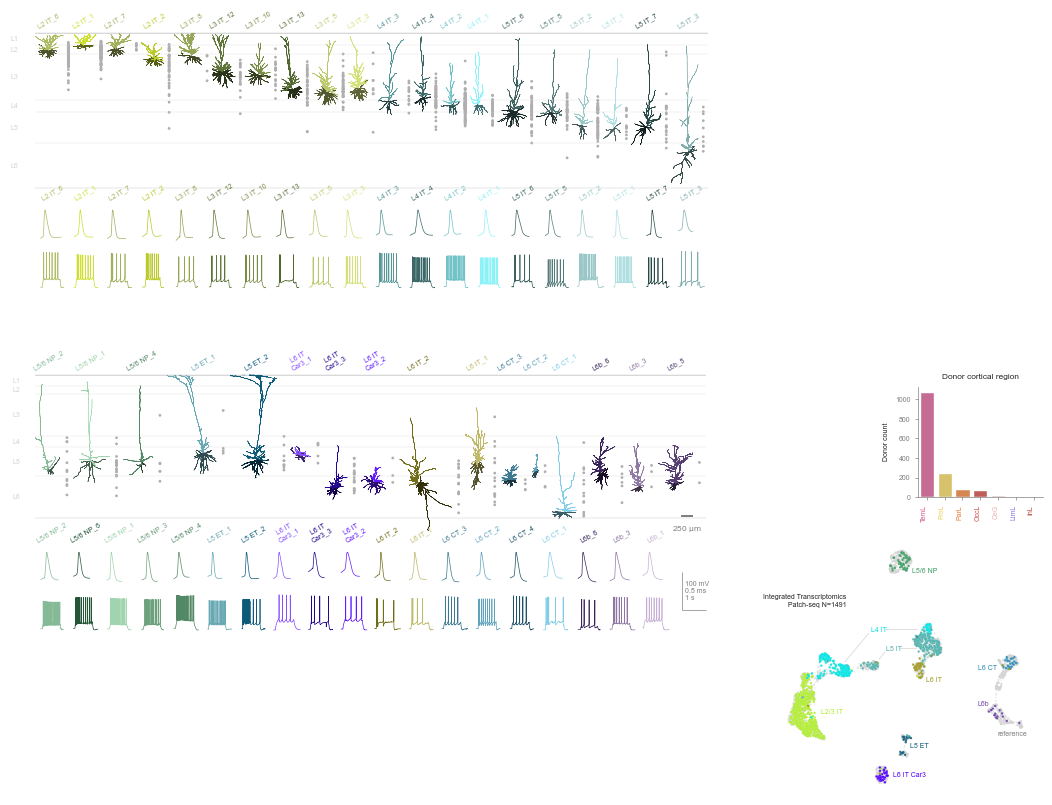

In [48]:
# plot templates
output_file = os.path.join(output_dir, f'subclass_1.pdf')

subclasses = list(tx_order_dict.keys())
morpho_subclass_order = [s for s in subclasses if s in morpho_sorted_clean_data['subclass_label'].unique()]
ephys_subclass_order = [s for s in subclasses if s in ephys_sorted_clean_data['subclass_label'].unique()]

fig = plt.figure(figsize=group_fig_size['subclass_1'])
gs = gridspec.GridSpec(2, 2, 
                       width_ratios=(8,3), 
                       height_ratios=(6,3),
                       wspace=0, 
                       hspace=0)

# ME gallery 
gs_gallery = gridspec.GridSpecFromSubplotSpec(
    2, 1, 
    subplot_spec=gs[0],
    hspace=1
)
ax_gallery_top = plt.subplot(gs_gallery[0])
plot_morpho_gallery(ax_gallery_top, gallery_cells[:20], morpho_sorted_clean_data, soma_depths, layer_info, layer_labels, color_dict, plot_scalebar=False)

ax_gallery_bottom = plt.subplot(gs_gallery[1])
plot_morpho_gallery(ax_gallery_bottom, gallery_cells[20:], morpho_sorted_clean_data, soma_depths, layer_info, layer_labels, color_dict, buffer=150)

# (ephys gallery plotted at the end)

# Col 2
gs_col2 = gridspec.GridSpecFromSubplotSpec(
    3, 2, 
    subplot_spec=gs[1],
    width_ratios=(1,1),
    height_ratios=(3,1,0.1))

#donor lobe count
ax_donor_region = plt.subplot(gs_col2[1,1])
plot_donor_lobe_counts(ax_donor_region, metadata, lobe_colors)

# Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    1, 1, 
    subplot_spec=gs[1, 1])

#reference UMAP
ax_umap_ref = plt.subplot(gs_row2[0])
reference_umap['color'] = reference_umap.apply(lambda row: color_dict[row['subclass']] if row['subclass'] in subclasses else 'lightgrey', axis=1)
plot_ref_umap(reference_umap, ax_umap_ref, label_dict=umap_labels['subclass'], line_list=umap_lines['subclass'])
ax_umap_ref.text(-5, 10, 'Integrated Transcriptomics\nPatch-seq N={}'.format(reference_umap.platform.value_counts()['patch-seq']), fontsize=5, ha='right', va='center')

#plot the ephys gallery (it corrupts the fig, so plot it last)
plot_ephys_gallery(fig, ax_gallery_top, svg_root, flatten([tx_order_dict[sub] for sub in subclasses if sub in tx_order_dict])[:20], color_dict, plot_scalebar=False)
plot_ephys_gallery(fig, ax_gallery_bottom, svg_root, flatten([tx_order_dict[sub] for sub in subclasses if sub in tx_order_dict])[20:], color_dict)

for ax in fig.get_axes():
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.tick_params(axis='both', length=2, width=0.5)

plt.savefig(output_file, bbox_inches="tight", dpi=600)


Subclass part 2

In [31]:
subclass_xoffsets = {'L2/3 IT': 1000-300, 
                     'L4 IT': 3000-600, 
                     'L5 IT': 5000-900, 
                     'L5/6 NP': 7000-1200, 
                     'L5 ET': 9000-1400, 
                     'L6 IT Car3': 11300-1500, 
                     'L6 IT': 13500-1500, 
                     'L6 CT': 15800-1600, 
                     'L6b': 17800-1700} 


heatmap_mask_dict = {'L4 IT': 2000-600, 
                     'L5 IT': 4000-900, 
                     'L5/6 NP': 6000-1200, 
                     'L5 ET': 8000-1400, 
                     'L6 IT Car3': 10000-1500, 
                     'L6 IT': 12000-1500, 
                     'L6 CT': 14000-1600, 
                     'L6b': 16000-1700}

heatmap_xlim = (0, 18500-1800)

ephys_umap_labels = {'L2/3 IT' : {'x':10, 'y':-0.5, 'ha': 'center', 'va':'center'},
                     'L4 IT' : {'x':0.2 , 'y':4 , 'ha': 'right', 'va': 'center'},
                     'L5 IT' : {'x': 1, 'y':5.5 , 'ha': 'right', 'va': 'center'},
                     'L5/6 NP' : {'x': 6.5, 'y':7 , 'ha': 'left', 'va': 'center'},
                     'L5 ET' : {'x': 7.8, 'y':-2, 'ha': 'left', 'va': 'center'},
                     'L6 IT Car3' : {'x':12, 'y':4, 'ha': 'left', 'va': 'center'},
                     'L6 IT' : {'x': 11.5, 'y': 5.1, 'ha': 'left', 'va': 'center'},
                     'L6 CT' : {'x': 11, 'y': 6.5, 'ha': 'left', 'va': 'center'},
                     'L6b' : {'x': 7.5, 'y': 7, 'ha': 'right', 'va': 'center'}}

morpho_umap_labels = {'L2/3 IT' : {'x':0, 'y':6.5, 'ha': 'center', 'va':'center'},
                     'L4 IT' : {'x':3 , 'y':-1 , 'ha': 'right', 'va': 'center'},
                     'L5 IT' : {'x': 6.5, 'y':1 , 'ha': 'left', 'va': 'center'}, 
                     'L5/6 NP' : {'x': 6, 'y':0 , 'ha': 'left', 'va': 'center'}, 
                     'L5 ET' : {'x': 6, 'y':4.3, 'ha': 'left', 'va': 'center'},
                     'L6 IT Car3' : {'x':2, 'y':2.5, 'ha': 'right', 'va': 'center'}, 
                     'L6 IT' : {'x': 7, 'y': 3, 'ha': 'left', 'va': 'center'}, 
                     'L6 CT' : {'x': 6.5, 'y': 2, 'ha': 'left', 'va': 'center'}, 
                     'L6b' : {'x': 6.5, 'y': 3.5, 'ha': 'left', 'va': 'center'}}

me_umap_labels = {'L2/3 IT': {'y': 6.5, 'x': 7, 'ha': 'center', 'va': 'center'},
                  'L4 IT': {'y': -0.8, 'x': 9, 'ha': 'right', 'va': 'center'},
                  'L5 IT': {'y': 1, 'x': 5.5, 'ha': 'left', 'va': 'center'},
                  'L5/6 NP': {'y': -1.5, 'x': 7, 'ha': 'right', 'va': 'center'},
                  'L5 ET': {'y': 3.2, 'x': 5, 'ha': 'left', 'va': 'center'},
                  'L6 IT Car3': {'y': 3, 'x': 8.4, 'ha': 'right', 'va': 'center'},
                  'L6 IT': {'y': 2, 'x': 5, 'ha': 'left', 'va': 'center'},
                  'L6 CT': {'y': 5.8, 'x': 6, 'ha': 'left', 'va': 'center'},
                  'L6b': {'y': 0, 'x': 6, 'ha': 'left', 'va': 'center'}}

heatmap_dendrite_cells = {
    'L2/3 IT' : 1084380898,
    'L4 IT' : 758312441,
    'L5 IT' : 1230988535,
    'L5/6 NP' : 1163016273,
    'L5 ET' : 1402898753,
    'L6 IT Car3' : 1161609703,
    'L6 IT' : 757173647,
    'L6 CT' : 1221146385,
    'L6b' : 592479953}

heatmap_axon_cells = {
    'L2/3 IT' : 689309060,
    'L4 IT' : 868182038,
    'L5 IT' : 695500665,
    'L5/6 NP' : 1164349747,
    'L5 ET' : 1161768653,
    'L6 IT Car3' : 1187969093,
    'L6 IT' : 793528028,
    'L6 CT' : 1310107671,
    'L6b' : 1161645348}

overlay_morphology = False #overlay morphos on the subclass heatmaps?
plot_hairball = True

\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:503: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="eta_squared", y='feature', data=eta_squared_ttypes_df, palette=color_palette)
\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\code\templates\template_utils.py:521: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), ha=label_ha, fontsize=6)  # Align labels to the left/right
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotatio

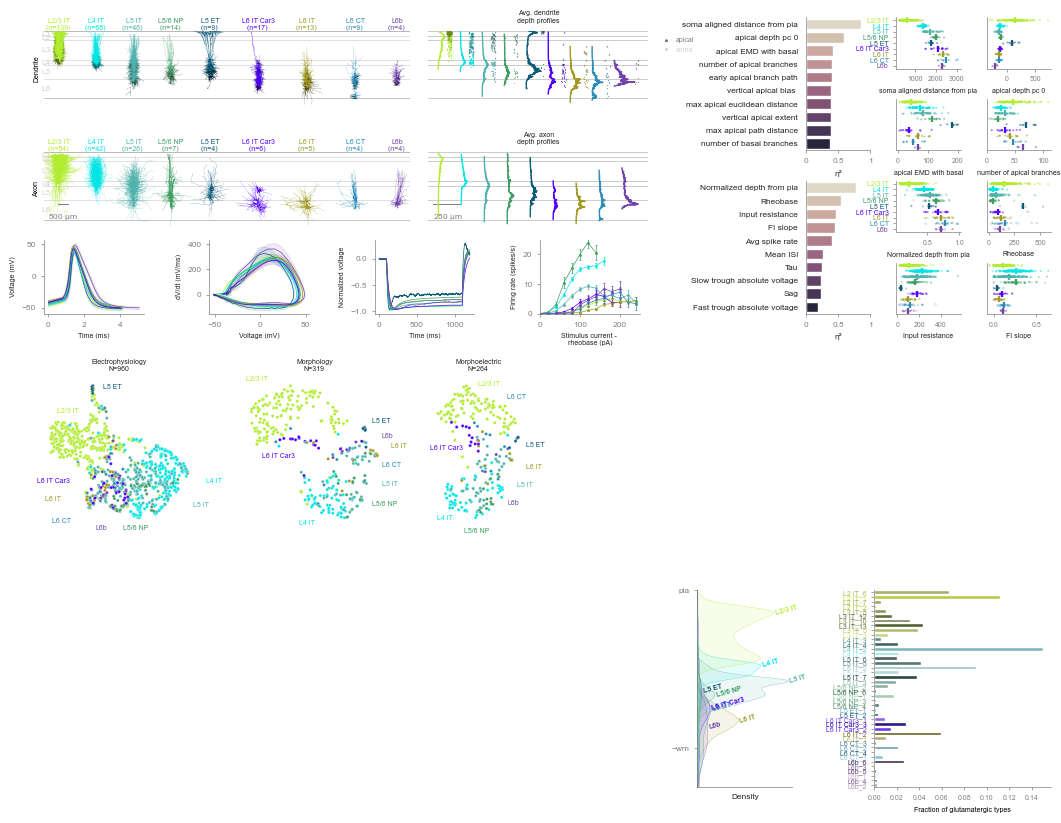

In [ ]:
# plot templates
output_file = os.path.join(output_dir, f'subclass_2.pdf')
# if plot_hairball:
#     output_file = output_file.replace('.pdf', '_hairball.pdf')
# if mark_paradigm:
#     output_file = output_file.replace('.pdf', f'_markParadigm_{mark_paradigm_type}.pdf')

subclasses = list(tx_order_dict.keys())
morpho_subclass_order = [s for s in subclasses if s in morpho_sorted_clean_data['subclass_label'].unique()]
ephys_subclass_order = [s for s in subclasses if s in ephys_sorted_clean_data['subclass_label'].unique()]

fig = plt.figure(figsize=group_fig_size['subclass_2'])
gs = gridspec.GridSpec(3, 1, height_ratios=(6, 3, 4), hspace=0.3, wspace=0.1)

gs_row1 = gridspec.GridSpecFromSubplotSpec(
    2, 2,
    subplot_spec=gs[0],
    width_ratios=(2,1),
    height_ratios=(3,1),
    wspace=0,
    hspace=0
)

gs_morph = gridspec.GridSpecFromSubplotSpec(
    2, 2,
    subplot_spec=gs_row1[0,0],
    width_ratios=(3,2),
    height_ratios=(1,1),
)

#dendrite
ax_morph_top = plt.subplot(gs_morph[0, 0])
if plot_hairball:
    plot_subclass_hairballs(ax_morph_top, morpho_sorted_clean_data, SUBCLASS_ORDER, layer_info, layer_colors, layer_labels, color_dict, subclass_xoffsets, compartment_list=[1,3,4], plot_scalebar=False, ylabel='Dendrite')
else:
    with open(os.path.join(heatmap_dir, 'dendrite', "heatmap_kde_subclass_dendrite.pkl"), "rb") as f: dend_kde_group_dict = pickle.load(f)
    plot_subclass_heatmap(ax_morph_top, dend_kde_group_dict, subclasses, layer_info, layer_colors, layer_labels, color_dict, subclass_xoffsets, plot_scalebar=False, ylabel='Dendrite', xlim=heatmap_xlim, ylim=heatmap_ylim, colormap=custom_cmap_d, color_seaad=True)
    if overlay_morphology: 
        overlay_morphologies(ax_morph_top, heatmap_dendrite_cells, subclass_xoffsets, morpho_sorted_clean_data, color_dict, compartment_type = 'dendrite', alpha=0.5, color_grey=False)

#axon 
ax_morph_bottom = plt.subplot(gs_morph[1, 0])
if plot_hairball:
    plot_subclass_hairballs(ax_morph_bottom, morpho_sorted_clean_data[morpho_sorted_clean_data.has_axon], SUBCLASS_ORDER, layer_info, layer_colors, layer_labels, color_dict, subclass_xoffsets, compartment_list=[1,2], plot_scalebar=True, ylabel='Axon')
else:
    with open(os.path.join(heatmap_dir, 'axon', "heatmap_kde_subclass_axon.pkl"), "rb") as f: axon_kde_group_dict = pickle.load(f)
    plot_subclass_heatmap(ax_morph_bottom, axon_kde_group_dict, subclasses, layer_info, layer_colors, layer_labels, color_dict, subclass_xoffsets, plot_subclass=False, mask_min_dict=heatmap_mask_dict, ylabel='Axon', xlim=heatmap_xlim, ylim=heatmap_ylim, colormap=custom_cmap_a, color_seaad=True)
    if overlay_morphology: 
        overlay_morphologies(ax_morph_bottom, heatmap_axon_cells, subclass_xoffsets, morpho_sorted_clean_data, color_dict, compartment_type = 'axon', alpha=0.5, color_grey=False)

#depth profiles
ax_profiles_top = ax_morph_top.inset_axes([1.05, 0, 0.6, 1], transform=ax_morph_top.transAxes)
ax_morph_top.sharey(ax_profiles_top)
profile_xoffets = plot_dendrite_depth_profiles_subclass(ax_profiles_top, morpho_sorted_clean_data, 'subclass_label', morpho_subclass_order, aligned_histogram, basal_cols, apical_cols, layer_edges, plot_scalebar=False) #, histo_xoffsets)
ax_profiles_top.set_title("Avg. dendrite\ndepth profiles", fontsize=5)
#plot distal apical tips and somas
plot_distal_apicals(subclass_apical_dict, SUBCLASS_ORDER, ax_profiles_top, profile_xoffets, apical_buffer_dict, color_dict)

ax_profiles_bottom = ax_morph_bottom.inset_axes([1.05, 0, 0.6, 1], transform=ax_morph_bottom.transAxes)
ax_morph_bottom.sharey(ax_profiles_bottom)
plot_axon_depth_profiles_subclass(ax_profiles_bottom, morpho_sorted_clean_data, 'subclass_label', morpho_subclass_order, aligned_histogram, axon_cols, layer_edges) #, histo_xoffsets)
ax_profiles_bottom.set_title("Avg. axon\ndepth profiles", fontsize=5)

for ax in [ax_morph_top, ax_morph_bottom]:
    ax.set_xlim(heatmap_xlim)
    ax.set_ylim(heatmap_ylim)

#EPHYS average trace plots 
gs_ephys_trace = gridspec.GridSpecFromSubplotSpec(
        1, 5,
        subplot_spec=gs_row1[1, 0],
        width_ratios=(1,1,1,1,0.1),
        wspace=0.8
)
ephys_subclass_col = 'HANN_subclass_label_assignment_winner' #TODO is this still correct?

# #rheobase (ap width)
plot_ap_subclass(ephys_ap_dict, color_dict, plt.subplot(gs_ephys_trace[0]), 'width')

#AP phase plot 
plot_ap_subclass(ephys_ap_dict, color_dict, plt.subplot(gs_ephys_trace[1]), 'phase')

#subthreshold response
subthresh_spike_data = np.load(os.path.join(ephys_subthresh_dir, 'subthreshold_data_subclass.npy'), allow_pickle=True)[()]
subthresh_metadata = pd.read_csv(os.path.join(ephys_subthresh_dir, 'subthreshold_metadata.csv'))
plot_ephys_subthresh(plt.subplot(gs_ephys_trace[2]), subthresh_spike_data, subthresh_metadata, list(tx_order_dict.keys()), ephys_subclass_col, color_dict)

#FI curve
plot_avg_fi_for_mets(plt.subplot(gs_ephys_trace[3]), ephys_fi_data_formatted, 'subclass_label', list(tx_order_dict.keys()))


#Morpho & Ephys feature plots

gs_feat_prop = gridspec.GridSpecFromSubplotSpec(
        4, 4,
        subplot_spec=gs_row1[:,1],
        width_ratios=(1,1,1,1),
        height_ratios=(1,1,1,1),
        hspace=0.6, wspace=0.4
)

#MORPHO
#eta2
if not morpho_eta_squared_subclass.empty:
    plot_subclass_eta2_topn(morpho_eta_squared_subclass, plt.subplot(gs_feat_prop[0:2,1]), label_right=False)

#get top four features 
eta_squared_df = morpho_eta_squared_subclass
eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
n_features = 4
top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
for i, feature in enumerate(top_features):
    plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[i // 2, 2 + (i % 2)]), morpho_subclass_order, morpho_sorted_clean_data, "subclass_label", feature, feature, 
                           show_yticklabels=(i==0))

#EPHYS
#eta2 
if not ephys_eta_squared_subclass.empty:
    plot_subclass_eta2_topn(ephys_eta_squared_subclass, plt.subplot(gs_feat_prop[2:4,1]), label_right=False)

#get top four features 
eta_squared_df = ephys_eta_squared_subclass
eta_squared_df['abs_eta_squared'] = eta_squared_df['eta_squared'].abs()
n_features = 4
top_features = eta_squared_df.sort_values(by='abs_eta_squared', ascending=False).head(n_features).feature.tolist()
for i, feature in enumerate(top_features):
    plot_prop_for_mets_swb(plt.subplot(gs_feat_prop[(i // 2)+2, 2 + (i % 2)]), ephys_subclass_order, ephys_sorted_clean_data, "subclass_label", feature, feature, 
                           show_yticklabels=(i==0), mark_paradigm=mark_paradigm, mark_paradigm_type=mark_paradigm_type)


#Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    1, 6, 
    subplot_spec=gs[1],
    width_ratios=(1.2, 1.1, 0.7,
                  1, 1, 1), 
    wspace=0.4
)

#patchseq UMAPs
ax_umap_e = plt.subplot(gs_row2[0])
plot_umap(ax_umap_e, e_umap, subclass_col, subclasses, color_dict, umap1_label='e-UMAP2', umap2_label='e-UMAP1', label_dict=ephys_umap_labels) #swap label order to flip both axes for better umap visual alignment across modalities 
ax_umap_e.set_title('Electrophysiology\nN={}'.format(len(e_umap)), size=5)
ax_umap_e.invert_xaxis()
ax_umap_e.invert_yaxis()

ax_umap_m = plt.subplot(gs_row2[1])
plot_umap(ax_umap_m, m_umap, subclass_col, subclasses, color_dict, umap1_label='m-UMAP1', umap2_label='m-UMAP2', label_dict=morpho_umap_labels)
ax_umap_m.set_title('Morphology\nN={}'.format(len(m_umap)), size=5)

ax_umap_me = plt.subplot(gs_row2[2])
plot_umap(ax_umap_me, me_umap, subclass_col, subclasses, color_dict, x_col='umap_2', y_col='umap_1', umap1_label='me-UMAP2', umap2_label='me-UMAP1', label_dict=me_umap_labels)
ax_umap_me.set_title('Morphoelectric\nN={}'.format(len(me_umap)), size=5)
ax_umap_me.invert_xaxis()

#Row 3
gs_row3 = gridspec.GridSpecFromSubplotSpec(
    1, 5, 
    subplot_spec=gs[2],
    width_ratios=(1,1,
                  1,0.7,1.3), 
    wspace=0.6
)

plot_spatial_density_kde(isodepth_df, plt.subplot(gs_row3[-2]), 'scaled_gaston_isodepth', 'SEAAD_Subclass_name', 
                         [s for s in subclasses if s in isodepth_df.SEAAD_Subclass_name.unique()], color_dict, label_peaks=True)


abundance_barplot(abundance_ref, [t for t in TTYPE_ORDER if t in abundance_ref.supertype.unique()], plt.subplot(gs_row3[-1]), SEAAD_COLORS, x_col= 'supertype_frac_of_class', y_col='supertype', title='Fraction of glutamatergic types')


for ax in fig.get_axes():
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.tick_params(axis='both', length=2, width=0.5)

plt.savefig(output_file, bbox_inches="tight", dpi=600)
